# Project Title: Generative Imputation of Missing Multi-Omics Data

# CSCI 5952 — Big Data Science  

**Project:** Cross-modal Generative Imputation for TCGA Pan-Cancer  

## Team Members
- Muhammad Babar  
- Kathryn Eron  
- Kavya Avula  
- Susmitha Rachuri  

## Brief overview  
This project investigates cross-modal generative imputation using multi-omics cancer data from the TCGA Pan-Cancer collection. The goal is to reconstruct missing CNV (copy number variation) signals from mRNA (transcriptomic) profiles and compare classical imputation baselines with a generative autoencoder approach.

## Motivation  
Real biomedical datasets often have missing omics modalities because of cost, sample quality, or technology limitations. Modeling cross-modal relationships allows us to impute missing assays, increasing dataset completeness and improving downstream tasks such as subtype classification and pathway discovery.

## Modalities  
- **mRNA (Transcriptomics):** gene expression profiles  
- **CNV (Genomics):** DNA copy number variation regions  
- **Labels file:** cancer type annotations for each patient (32 classes), used for downstream classification  

## Methods  
### Baseline imputations  
- Mean imputation  
- K-Nearest Neighbors (KNN)  
- Linear regression  

### Generative model  
- Autoencoder trained to reconstruct CNV from mRNA (cross-omics reconstruction)

## Evaluation  
- **Quantitative:** MSE, R², Pearson correlation  
- **Visual:** PCA, UMAP, distribution comparisons  
- **Downstream:** Random Forest classifier using cancer-type labels  

## Dataset  
- **Source:** TCGA Pan-Cancer (Multi-Omics Benchmark)  
- **Samples:** 8,314 patients  
- **Features:** mRNA (3,217 genes), CNV (3,105 regions)  
- **Labels:** 32 cancer types  

## Objective  
Show that a generative cross-modal model can learn meaningful mappings from mRNA to CNV and outperform traditional imputation methods in both reconstruction accuracy and downstream performance.


# Step 1: Setup Environment

In [26]:
# --- Install and import dependencies ---
!pip install -q pandas numpy scikit-learn matplotlib seaborn torch torchvision torchaudio tqdm umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Environment ready!")


Environment ready!


# Step 2: Load Dataset 

In [27]:
# Step 2: Load Dataset (Cloud Notebook Version - Files Uploaded)

import os
import pandas as pd

print("Current working directory:", os.getcwd())
print("Files available:", os.listdir("."))

# Expected filenames
files = [
    "Pan-cancer_mRNA.csv",
    "Pan-cancer_CNV.csv",
    "Pan-cancer_label_num.csv"
]

print("\n Checking uploaded files...")
for f in files:
    if os.path.isfile(f):
        print(f"Found: {f}")
    else:
        print(f"Missing: {f} ❗ Make sure it is uploaded correctly.")

# Load the CSVs (since they are in the current directory)
mRNA = pd.read_csv("Pan-cancer_mRNA.csv", index_col=0)
CNV = pd.read_csv("Pan-cancer_CNV.csv", index_col=0)
labels_df = pd.read_csv("Pan-cancer_label_num.csv")

print("\nData Loaded Successfully!")
print("mRNA shape:", mRNA.shape)
print("CNV shape:", CNV.shape)
print("Labels shape:", labels_df.shape)

labels_df.head()

Current working directory: /home/jupyter
Files available: ['Pan-cancer_mRNA.csv', '.local', '.cache', '.npm', '.docker', 'Pan-cancer_label_num.csv', '.config', '.ipython', 'Pan-cancer_CNV.csv', '.jupyter', '.ipynb_checkpoints', 'CSI5952_GenerativeImputationOfMissingOmics.ipynb', '.bashrc', 'label_distribution_plot.png']

 Checking uploaded files...
Found: Pan-cancer_mRNA.csv
Found: Pan-cancer_CNV.csv
Found: Pan-cancer_label_num.csv

Data Loaded Successfully!
mRNA shape: (3217, 8314)
CNV shape: (3105, 8314)
Labels shape: (8314, 1)


Label
0     19
1     29
2     24
3     15
4      2

# Step 3: Clean and Align Labels

In [28]:
# --- Extract label column safely ---
if labels_df.shape[1] == 1:
    labels = labels_df.iloc[:, 0].values
else:
    # Try common column names like 'Label' or 'CancerType'
    possible_cols = [c for c in labels_df.columns if "label" in c.lower() or "type" in c.lower()]
    if possible_cols:
        labels = labels_df[possible_cols[0]].values
    else:
        labels = labels_df.iloc[:, 0].values  # fallback

# Convert to numeric if possible
labels = pd.to_numeric(labels, errors="coerce")
labels = np.nan_to_num(labels, nan=-1).astype(int)  # replace missing with -1 if any

print("Labels loaded and cleaned")
print("Labels shape:", labels_df.shape)
print("Unique label values:", np.unique(labels))

Labels loaded and cleaned
Labels shape: (8314, 1)
Unique label values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


# Step 4: Explore and Display Sample Records

Dataset Summary

mRNA (Transcriptomics):


TCGA-IB-AAUW-01  TCGA-AJ-A3EJ-01  TCGA-EE-A29D-06  TCGA-55-7725-01  \
sample                                                                        
KRT5            0.565732        -0.063888        -1.154331        -0.519646   
KRT6A          -0.122688        -0.114109        -0.687172        -0.635699   
CEACAM5         0.948782        -0.845083        -0.989103         1.333442   
KRT14           0.080169        -0.316703        -0.578278         0.008010   
RPS4Y1         -1.171622        -1.171622         0.877307        -1.171622   

         TCGA-AO-A0JJ-01  TCGA-AR-A24T-01  TCGA-EA-A1QT-01  TCGA-CJ-4897-01  \
sample                                                                        
KRT5            0.653508         0.543788         1.654486        -1.191466   
KRT6A          -0.294263        -0.819285         1.642827        -0.987429   
CEACAM5         1.050872         0.565945         0.979773        -1.045617   
KRT14           0.915403         0.621357         1.572045        -0.426745   
RPS4Y1         -1.171622        -1.171622        -1.171622        -0.804678   

         TCGA-DD-AAE4-01  TCGA-BP-5182-01  ...  TCGA-BH-A0BM-01  \
sample                                     ...                    
KRT5           -1.248858        -0.848804  ...         0.926962   
KRT6A          -0.987429        -0.673446  ...        -0.632268   
CEACAM5        -1.045617        -1.045617  ...         0.903206   
KRT14          -1.052720        -0.374430  ...         1.171566   
RPS4Y1         -0.763699         1.152981  ...        -0.884772   

         TCGA-WX-AA47-01  TCGA-BB-7863-01  TCGA-55-6971-01  TCGA-X7-A8DB-01  \
sample                                                                        
KRT5           -1.063179         2.076484        -0.352535         1.218985   
KRT6A          -0.798696         2.442369         0.313115        -0.265095   
CEACAM5        -0.223429         0.768301         1.617835        -1.045617   
KRT14          -1.052720         2.585872        -0.875931         1.458396   
RPS4Y1         -0.851244        -1.080352        -1.171622        -1.171622   

         TCGA-BR-8484-01  TCGA-33-4587-01  TCGA-D5-5541-01  TCGA-DX-A3LU-01  \
sample                                                                        
KRT5           -0.835300         1.036682        -0.977092        -1.066555   
KRT6A          -0.738644         0.295957        -0.661435        -0.987429   
CEACAM5         0.870391        -0.722940         1.922282        -1.045617   
KRT14          -0.924638         0.072953        -1.052720        -1.052720   
RPS4Y1          0.596045        -1.171622         1.134354         1.303856   

         TCGA-HS-A5NA-01  
sample                    
KRT5           -1.248858  
KRT6A          -0.987429  
CEACAM5        -0.938058  
KRT14          -1.052720  
RPS4Y1         -1.171622  

[5 rows x 8314 columns]


Shape: (3217, 8314)

CNV (Genomics):


TCGA-IB-AAUW-01  TCGA-AJ-A3EJ-01  TCGA-EE-A29D-06  \
Sample                                                                         
EGFR                             -0.407662        -0.036677         1.716913   
CCND1                            -0.244089        -0.780234        -0.139983   
ORAOV1                           -0.244330        -0.780794        -0.140162   
SNORA73|ENSG00000252054.1        -0.411146        -0.025439         1.797740   
FGF19                            -0.241204        -0.781814        -0.136232   

                           TCGA-55-7725-01  TCGA-AO-A0JJ-01  TCGA-AR-A24T-01  \
Sample                                                                         
EGFR                             -0.409380        -0.405945        -0.405945   
CCND1                            -0.249295        -0.245391        -0.241487   
ORAOV1                           -0.249538        -0.245632        -0.241726   
SNORA73|ENSG00000252054.1        -0.412931        -0.409360        -0.409360   
FGF19                            -0.246453        -0.242516        -0.238580   

                           TCGA-EA-A1QT-01  TCGA-CJ-4897-01  TCGA-DD-AAE4-01  \
Sample                                                                         
EGFR                             -0.304611         0.119617        -0.399075   
CCND1                             4.514847        -0.244089        -0.259705   
ORAOV1                            4.517436        -0.244330        -0.259955   
SNORA73|ENSG00000252054.1        -0.304005         0.137058        -0.402217   
FGF19                             4.557364        -0.241204        -0.256950   

                           TCGA-BP-5182-01  ...  TCGA-BH-A0BM-01  \
Sample                                      ...                    
EGFR                             -0.409380  ...        -0.404227   
CCND1                            -0.238884  ...        -0.246692   
ORAOV1                           -0.239121  ...        -0.246934   
SNORA73|ENSG00000252054.1        -0.412931  ...        -0.407574   
FGF19                            -0.235956  ...        -0.243829   

                           TCGA-WX-AA47-01  TCGA-BB-7863-01  TCGA-55-6971-01  \
Sample                                                                         
EGFR                             -0.417967         0.418466        -0.165492   
CCND1                            -0.234980        -0.232377        -0.094437   
ORAOV1                           -0.235215        -0.232611        -0.094589   
SNORA73|ENSG00000252054.1        -0.421860         0.447766        -0.159365   
FGF19                            -0.232019        -0.229395        -0.090306   

                           TCGA-X7-A8DB-01  TCGA-BR-8484-01  TCGA-33-4587-01  \
Sample                                                                         
EGFR                             -0.366442        -0.318351        -0.428273   
CCND1                            -0.251897        -0.215460        -0.747701   
ORAOV1                           -0.252142        -0.215684        -0.748241   
SNORA73|ENSG00000252054.1        -0.368289        -0.318290        -0.432574   
FGF19                            -0.249077        -0.212337        -0.749010   

                           TCGA-D5-5541-01  TCGA-DX-A3LU-01  TCGA-HS-A5NA-01  
Sample                                                                        
EGFR                              0.980096        -0.409380        -0.402510  
CCND1                             0.622592        -0.253198        -0.205050  
ORAOV1                            0.622866        -0.253445        -0.205267  
SNORA73|ENSG00000252054.1         1.031683        -0.412931        -0.405789  
FGF19                             0.632694        -0.250389        -0.201840  

[5 rows x 8314 columns]


Shape: (3105, 8314)

Common sample IDs between mRNA and CNV: 8314

Missing values summary:
mRNA missing values: 0
CNV missing values: 0


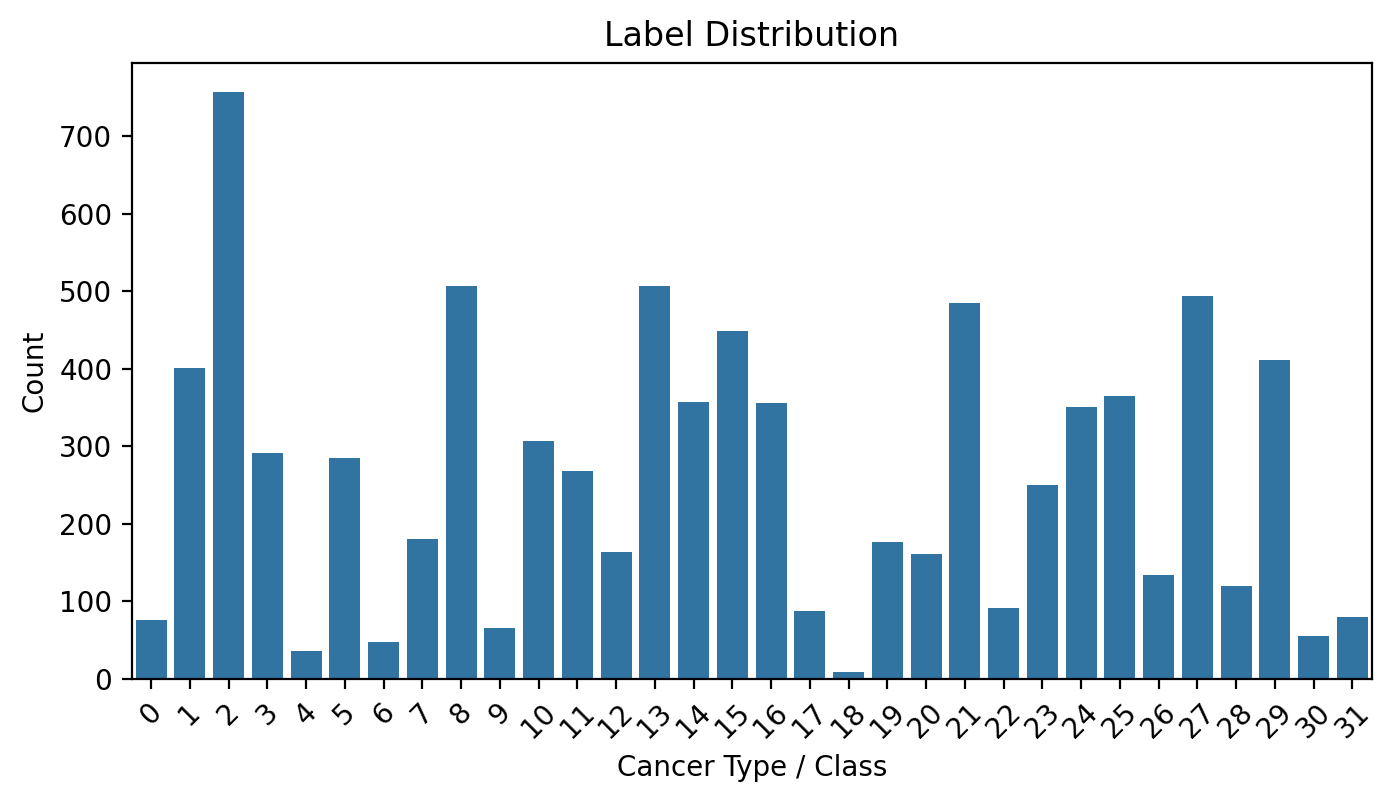

In [29]:
print("Dataset Summary\n")

print("mRNA (Transcriptomics):")
display(mRNA.head(5))
print("\nShape:", mRNA.shape)

print("\nCNV (Genomics):")
display(CNV.head(5))
print("\nShape:", CNV.shape)

# Check sample alignment
common_samples = set(mRNA.columns).intersection(set(CNV.columns))
print(f"\nCommon sample IDs between mRNA and CNV: {len(common_samples)}")

print("\nMissing values summary:")
print("mRNA missing values:", mRNA.isna().sum().sum())
print("CNV missing values:", CNV.isna().sum().sum())

# Visualize label distribution
plt.figure(figsize=(8,4))
sns.countplot(x=labels)
plt.title("Label Distribution")
plt.xlabel("Cancer Type / Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Step 4.1: Feature Count and Data Coverage Per Modality

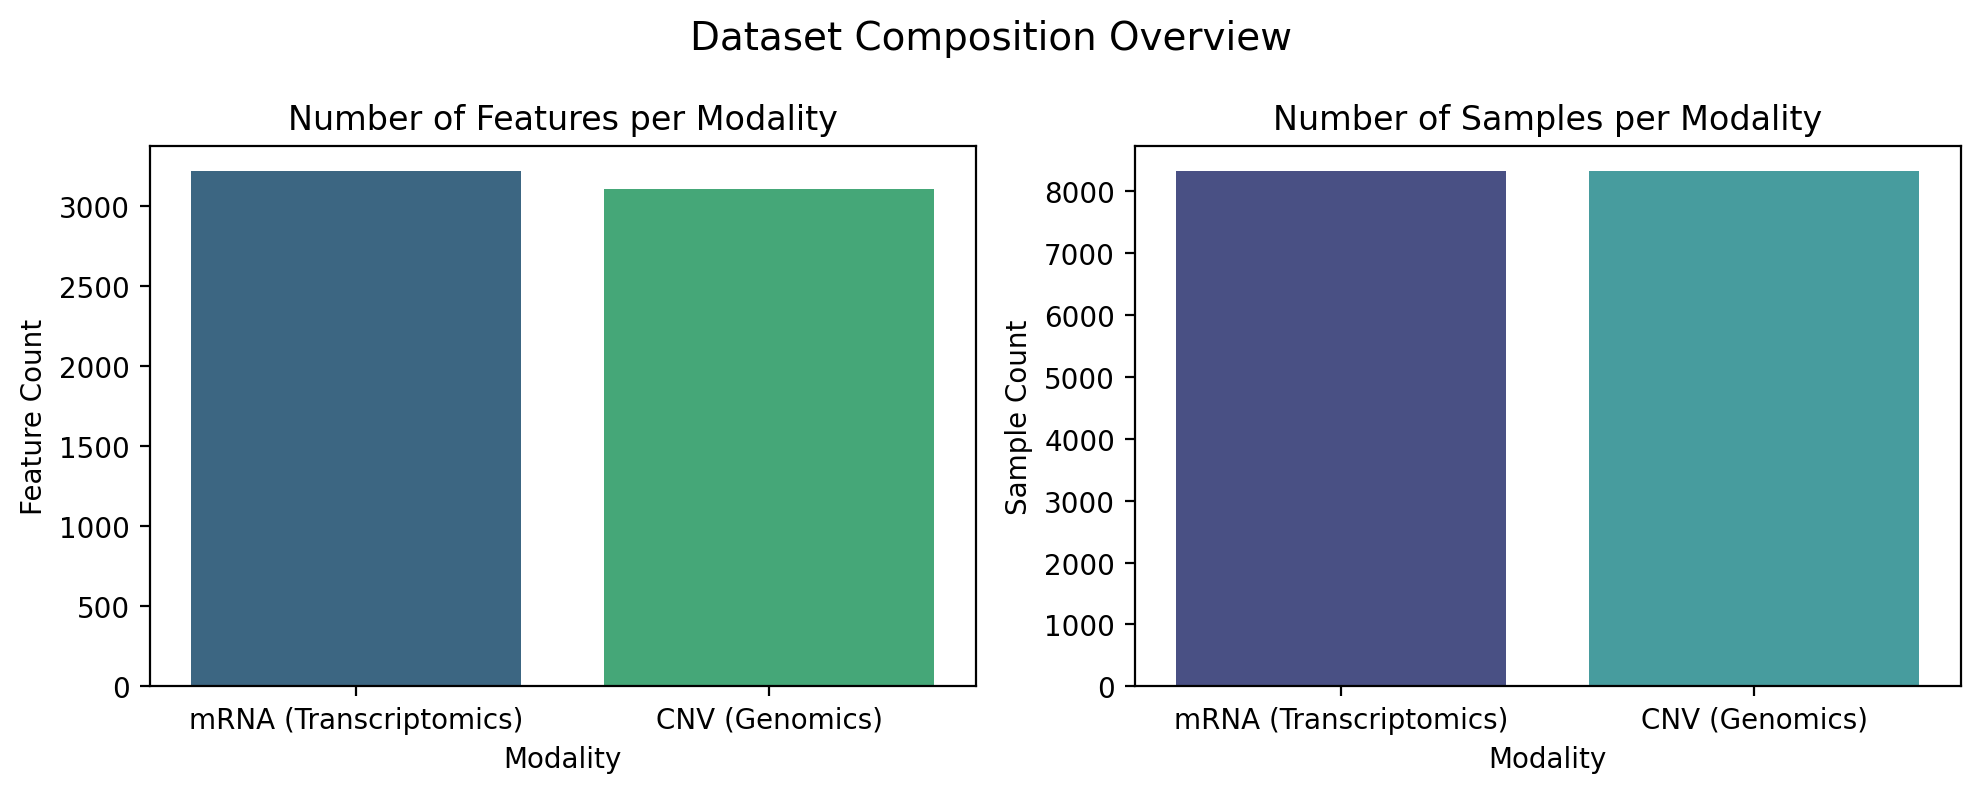

In [30]:
# --- Visual summary of dataset dimensions ---
modalities = ['mRNA (Transcriptomics)', 'CNV (Genomics)']
features = [mRNA.shape[0], CNV.shape[0]]
samples = [mRNA.shape[1], CNV.shape[1]]

# Create a DataFrame for seaborn compatibility
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_summary = pd.DataFrame({
    'Modality': modalities,
    'Features': features,
    'Samples': samples
})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Features per modality ---
sns.barplot(data=df_summary, x='Modality', y='Features', hue='Modality',
            palette='viridis', legend=False, ax=ax[0])
ax[0].set_title("Number of Features per Modality")
ax[0].set_ylabel("Feature Count")

# --- Samples per modality ---
sns.barplot(data=df_summary, x='Modality', y='Samples', hue='Modality',
            palette='mako', legend=False, ax=ax[1])
ax[1].set_title("Number of Samples per Modality")
ax[1].set_ylabel("Sample Count")

plt.suptitle("Dataset Composition Overview", fontsize=14)
plt.tight_layout()
plt.show()

This chart visually compares how rich each omics modality is in terms of features (genes) and samples (patients). Here, mRNA has slightly more gene-level features, but both share the same 8,314 samples.

# Step 4.2: Distribution of Feature Values

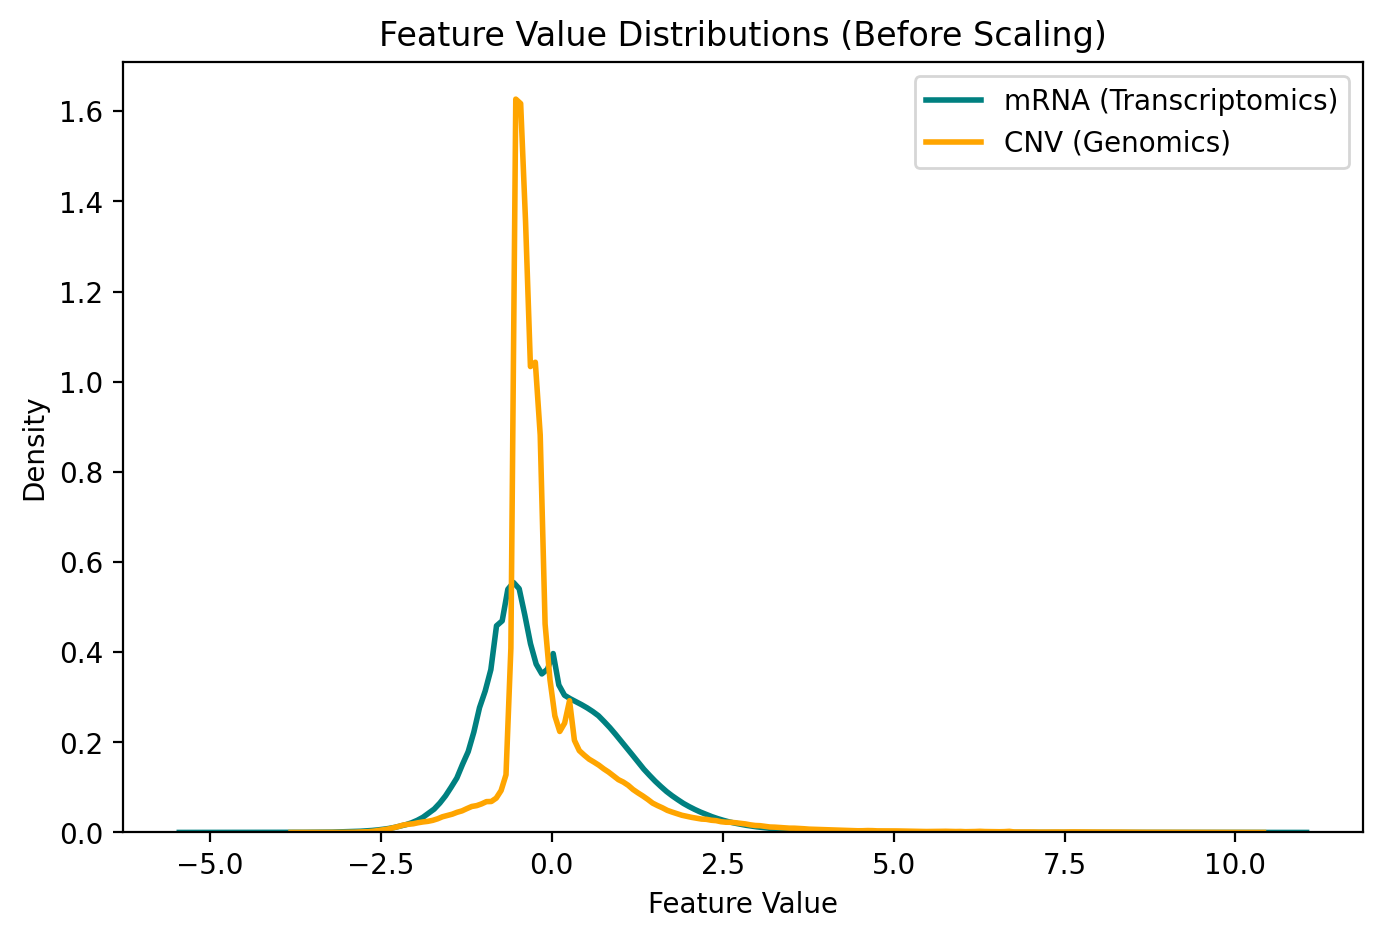

In [18]:
# --- Distribution comparison ---
plt.figure(figsize=(8,5))
sns.kdeplot(mRNA.values.flatten(), label="mRNA (Transcriptomics)", color="teal", linewidth=2)
sns.kdeplot(CNV.values.flatten(), label="CNV (Genomics)", color="orange", linewidth=2)
plt.title("Feature Value Distributions (Before Scaling)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()

mRNA values tend to center around zero due to normalization, while CNV values may show broader variation, reflecting genomic amplifications and deletions.

# Step 4.3: Missing Value Heatmaps

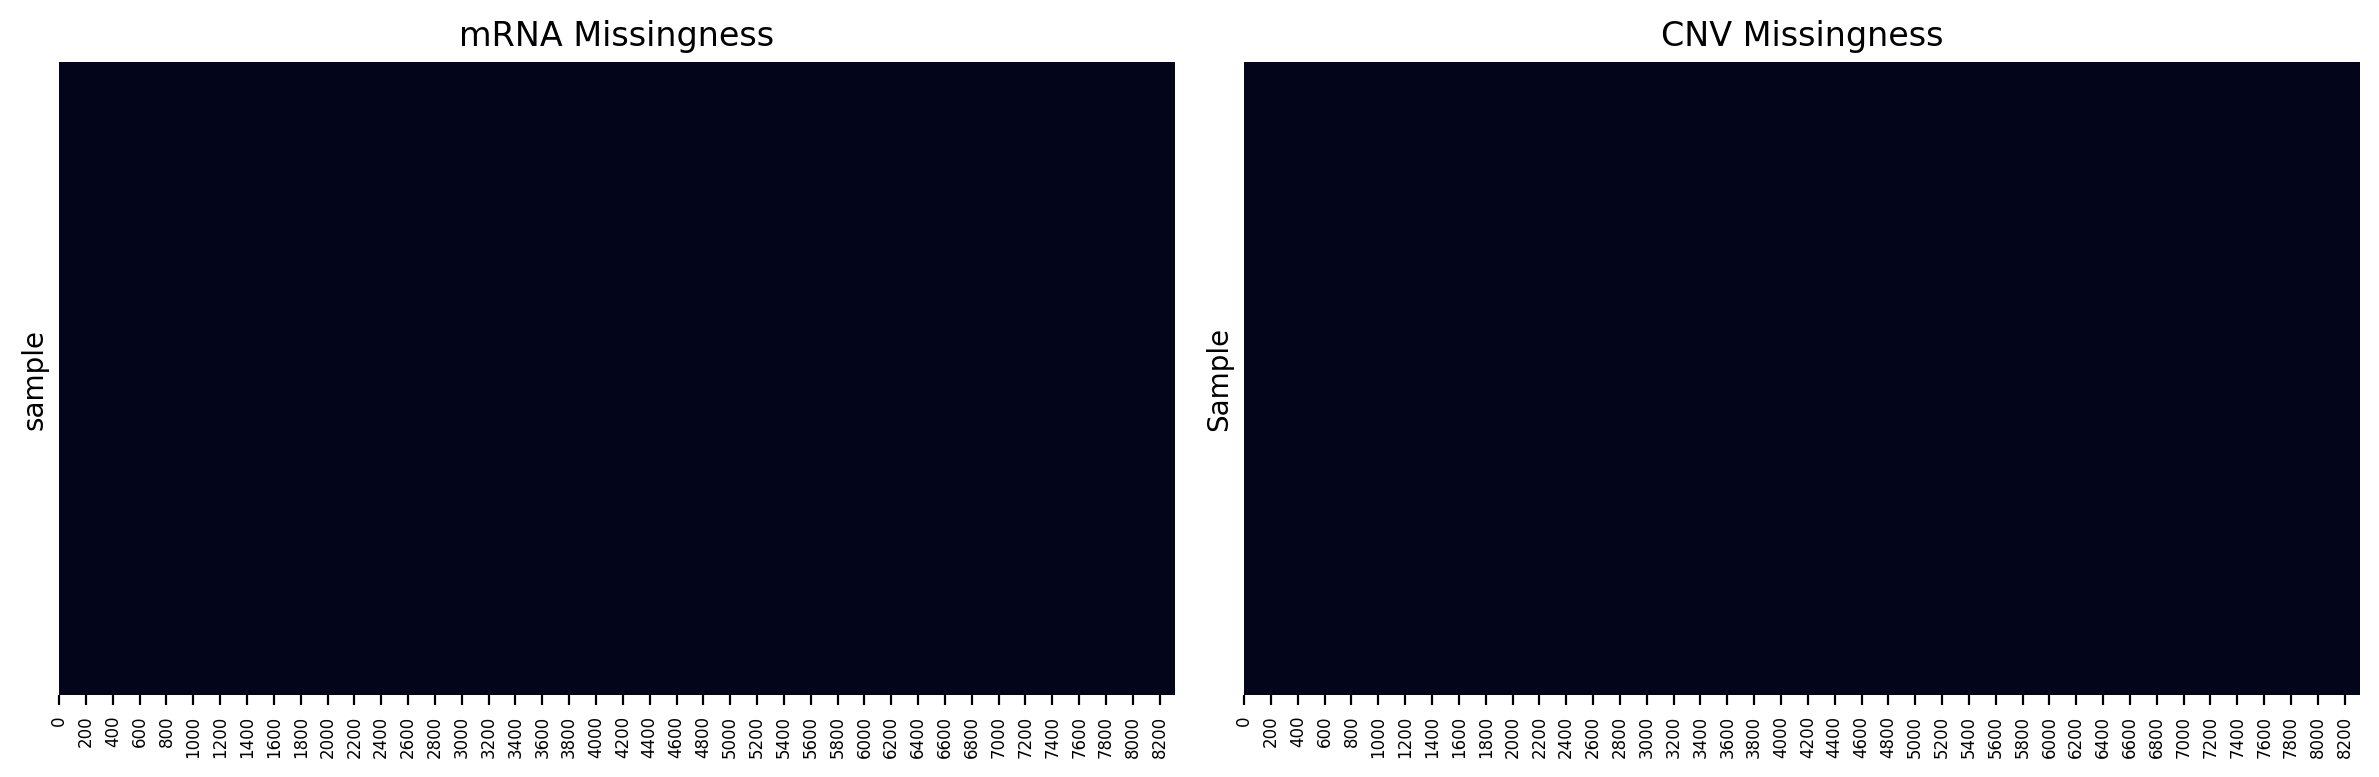

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(mRNA.isna(), cbar=False, ax=ax[0])
sns.heatmap(CNV.isna(), cbar=False, ax=ax[1])

ax[0].set_title("mRNA Missingness")
ax[1].set_title("CNV Missingness")

for a in ax:
    a.set_xticks(range(0, mRNA.shape[1], 200))
    a.set_xticklabels(range(0, mRNA.shape[1], 200), rotation=90, fontsize=6)
    a.set_yticks([])

plt.tight_layout()
plt.show()


Both modalities show no missing entries confirming they’re clean before we simulate missingness later for imputation experiments.

# Step 5: Data Preprocessing and Alignment

In [34]:
# --- Align by shared samples and scale ---
common_samples = mRNA.columns.intersection(CNV.columns)
mRNA = mRNA[common_samples]
CNV = CNV[common_samples]

# Transpose so rows = samples
mRNA_T = mRNA.T
CNV_T = CNV.T

# Standardize features
scaler = StandardScaler()
mRNA_scaled = pd.DataFrame(scaler.fit_transform(mRNA_T), index=mRNA_T.index, columns=mRNA_T.columns)
CNV_scaled = pd.DataFrame(scaler.fit_transform(CNV_T), index=CNV_T.index, columns=CNV_T.columns)

print("Data aligned and scaled")
print(f"mRNA_scaled: {mRNA_scaled.shape}, CNV_scaled: {CNV_scaled.shape}")

Data aligned and scaled
mRNA_scaled: (8314, 3217), CNV_scaled: (8314, 3105)


# Step 5.1: Visualize Data Relationships (Before Imputation) 
This shows how sample distributions differ in their lower-dimensional structure — a visual cue for why cross-omic imputation can help.

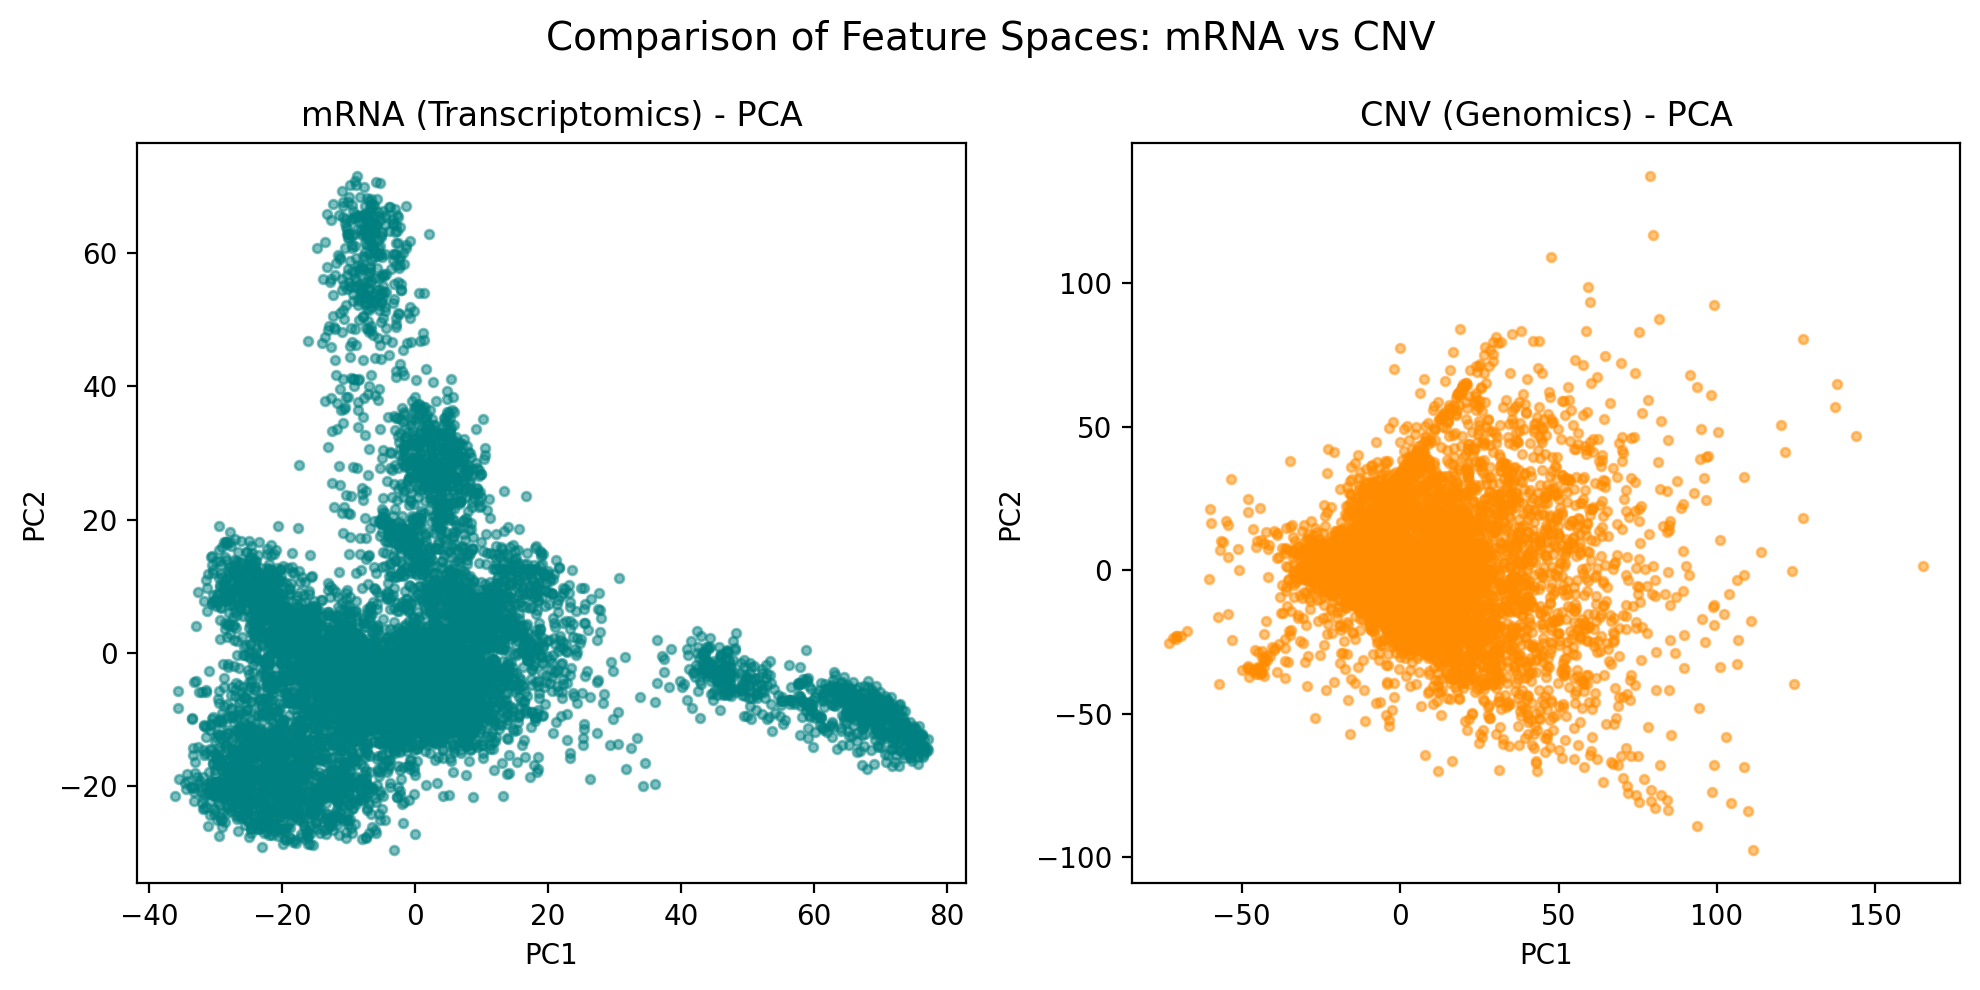

In [35]:
# --- PCA visualization of mRNA vs CNV spaces ---

from sklearn.decomposition import PCA

pca_mRNA = PCA(n_components=2).fit_transform(mRNA_scaled)
pca_CNV = PCA(n_components=2).fit_transform(CNV_scaled)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(pca_mRNA[:,0], pca_mRNA[:,1], s=10, alpha=0.5, color='teal')
plt.title("mRNA (Transcriptomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_CNV[:,0], pca_CNV[:,1], s=10, alpha=0.5, color='darkorange')
plt.title("CNV (Genomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.suptitle("Comparison of Feature Spaces: mRNA vs CNV", fontsize=14)
plt.tight_layout()
plt.show()

This plot shows how mRNA and CNV data occupy very different patterns when reduced to two principal components. The mRNA samples form clearer clusters, while CNV points are more spread out. This difference suggests that each modality captures unique biological variation, which motivates using cross-modal learning to improve imputation.

# Step 6: Simulating Missing Omics Data


 Random Missingness – 5%


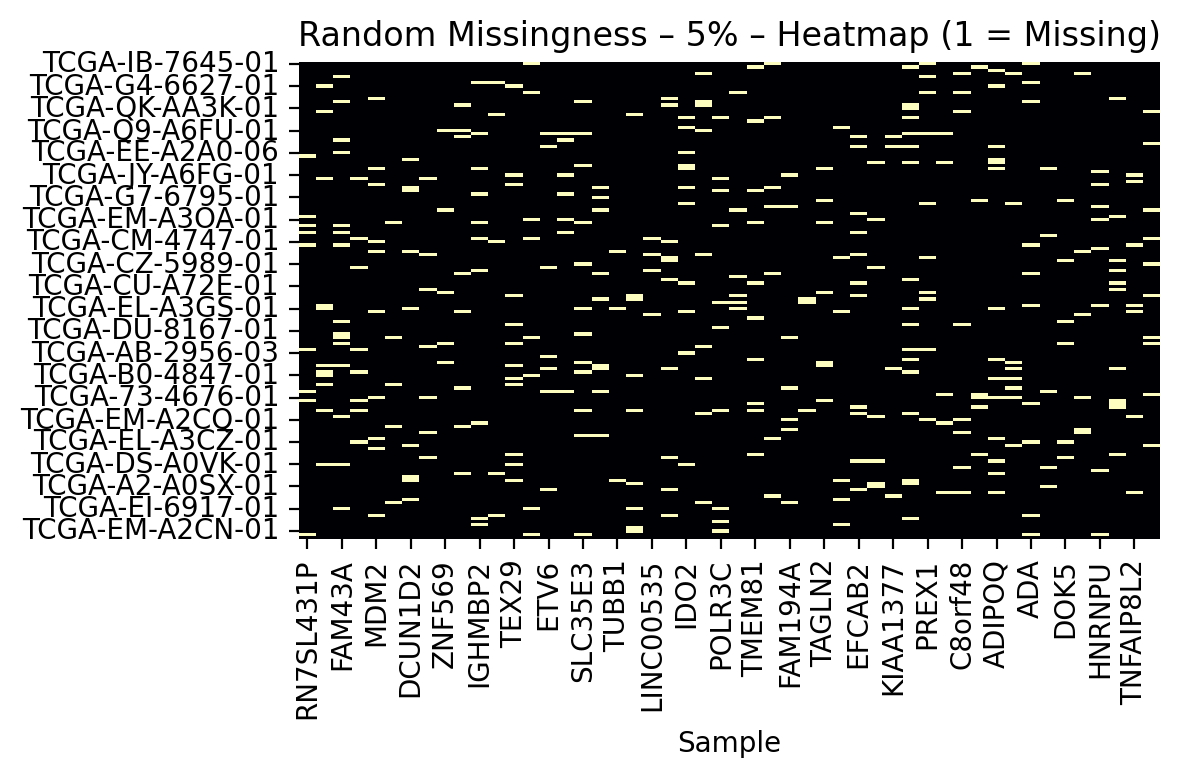

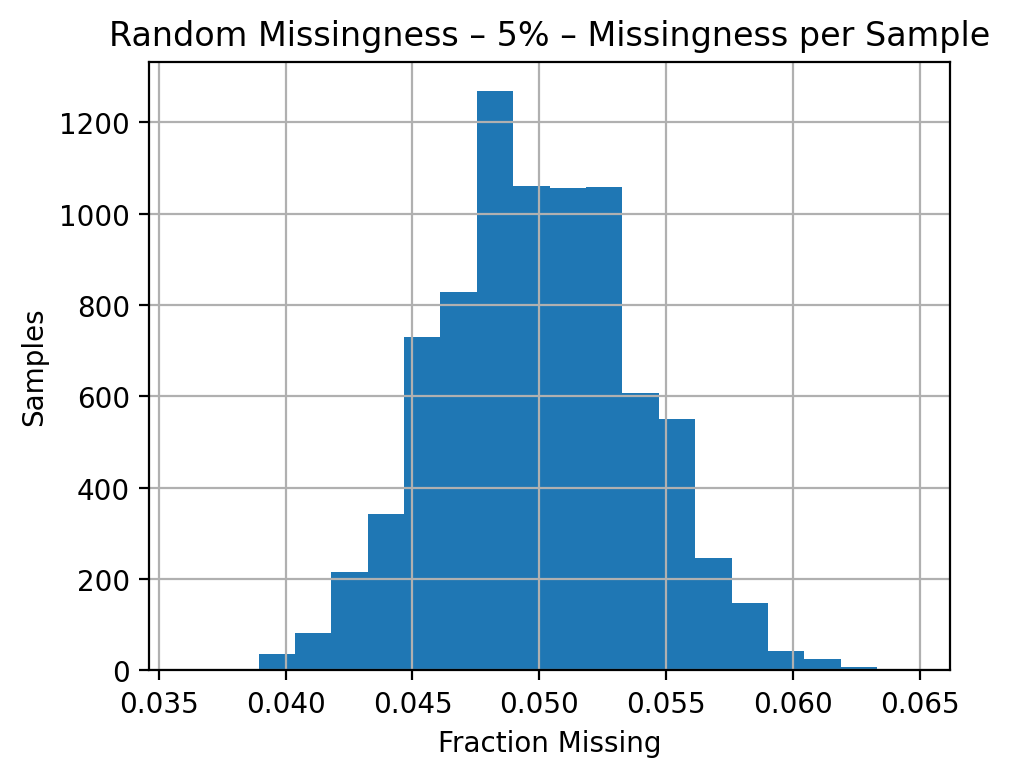

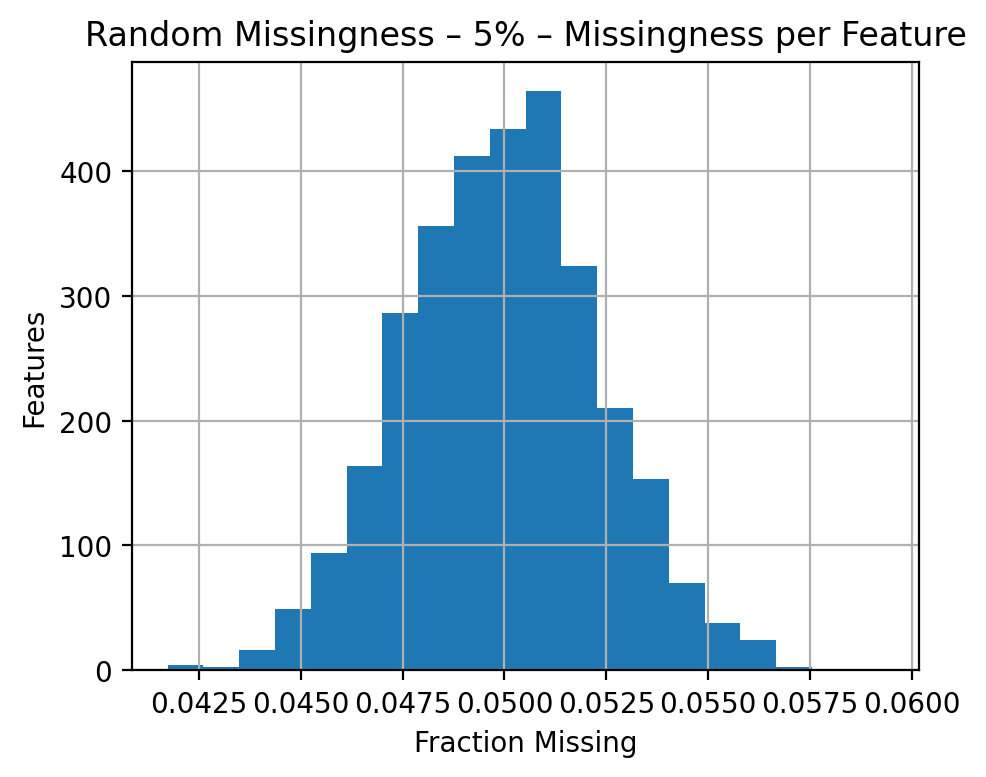


 Targeted-Samples Missingness – 5%


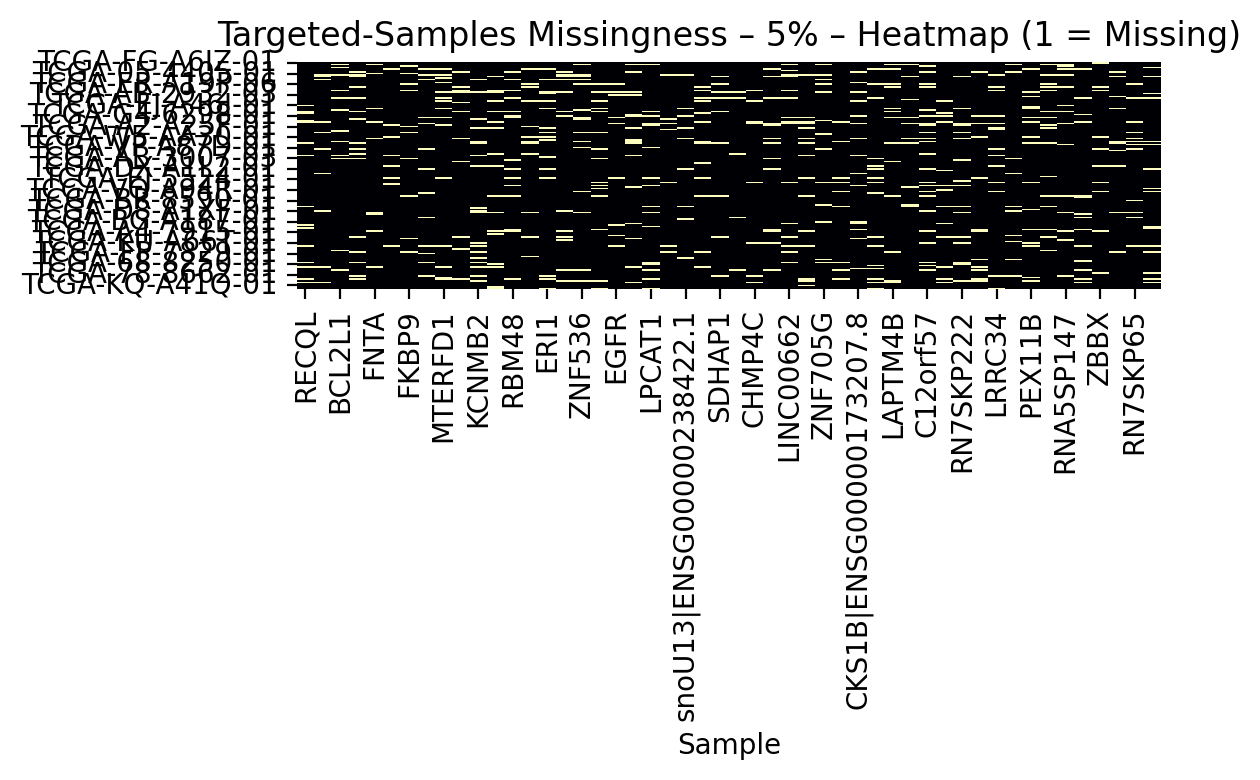

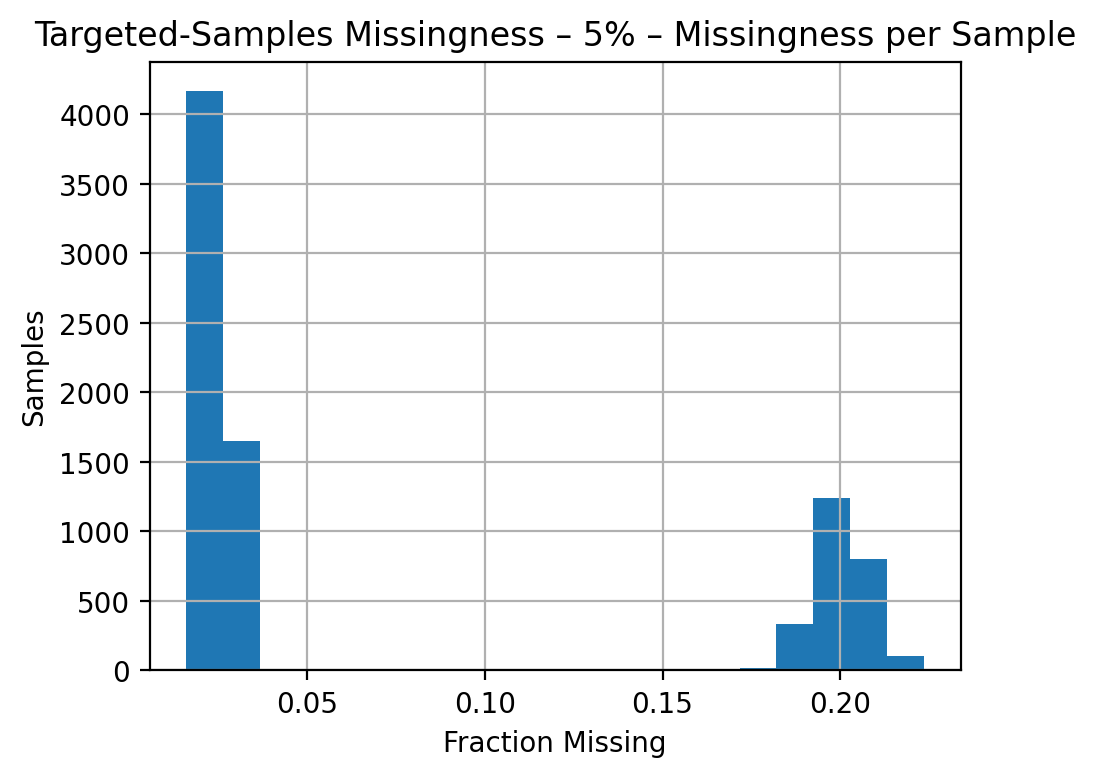

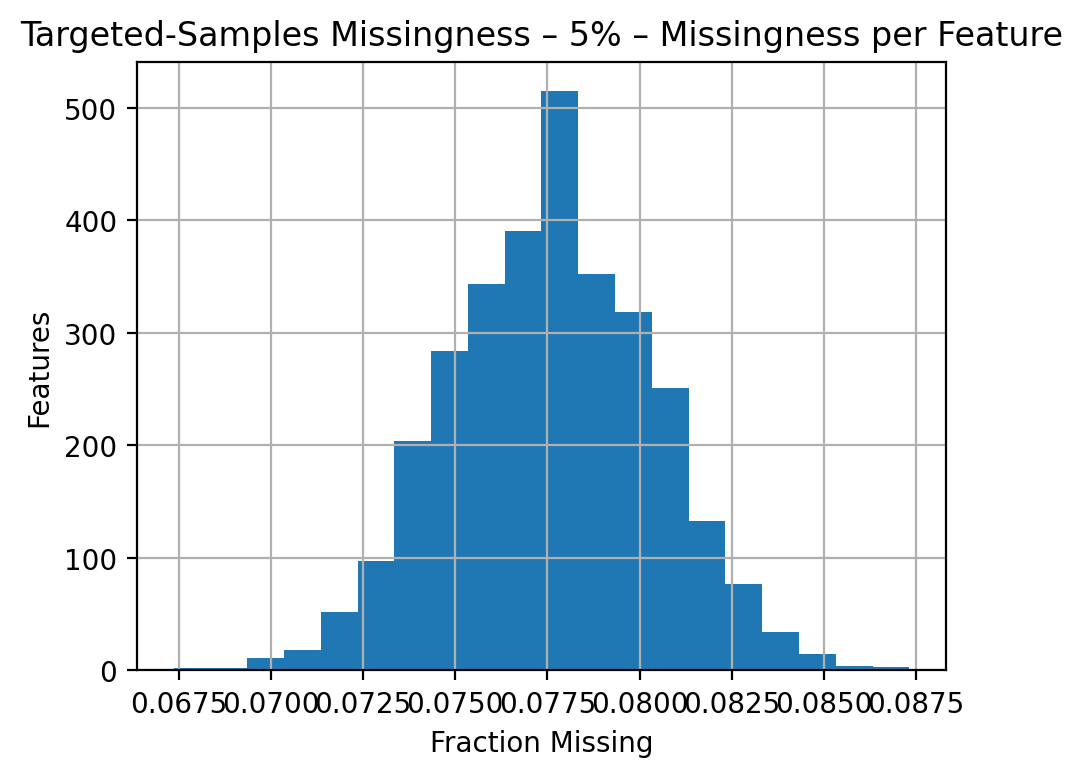


 Targeted-Features Missingness – 5%


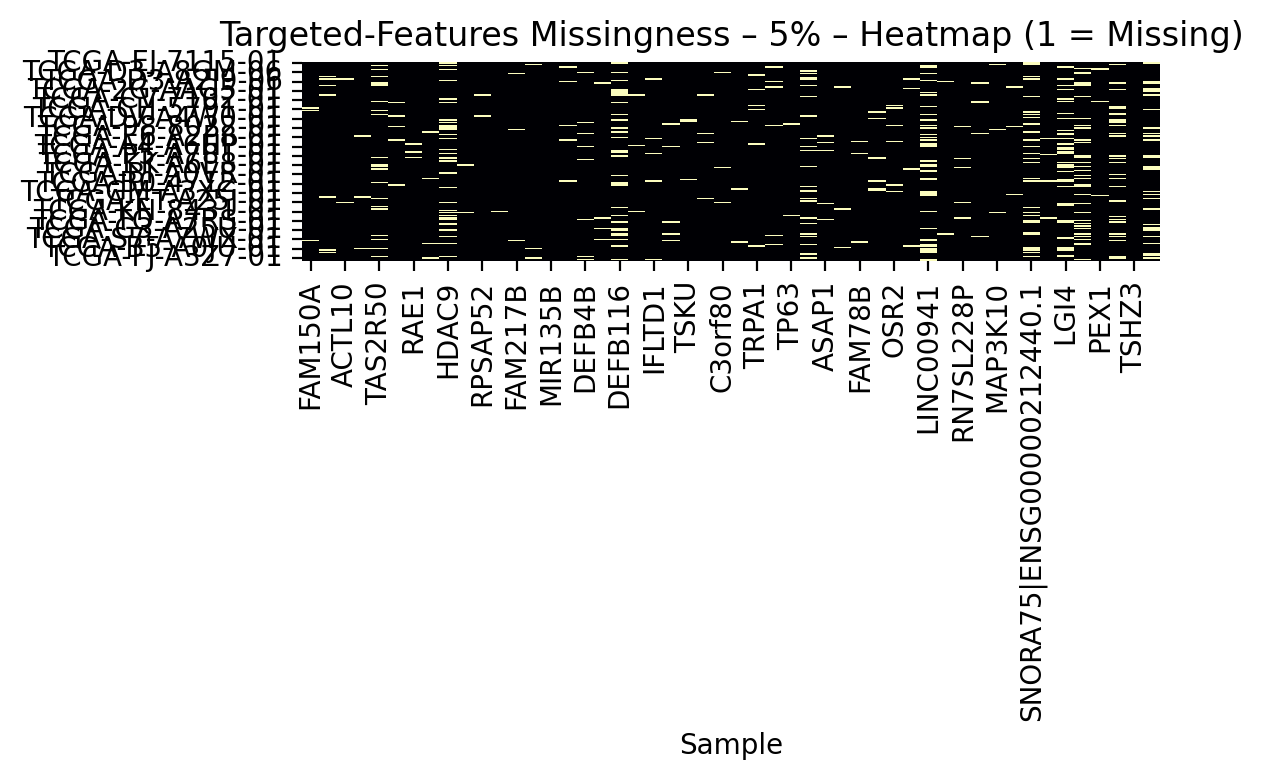

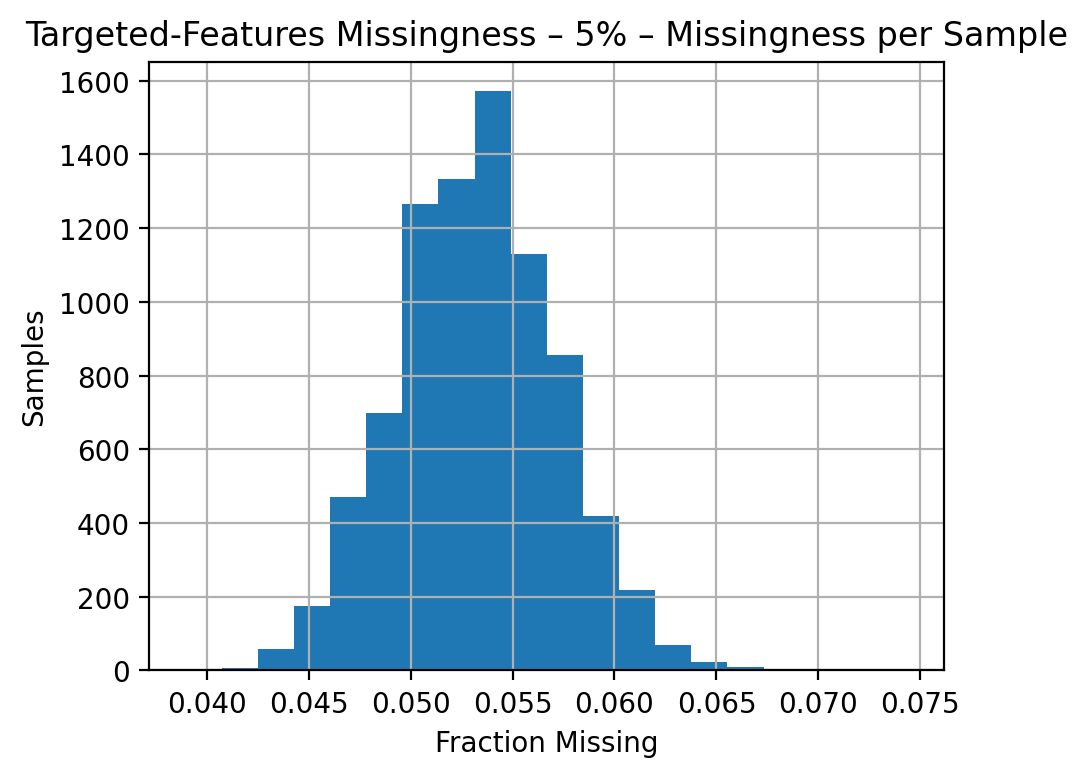

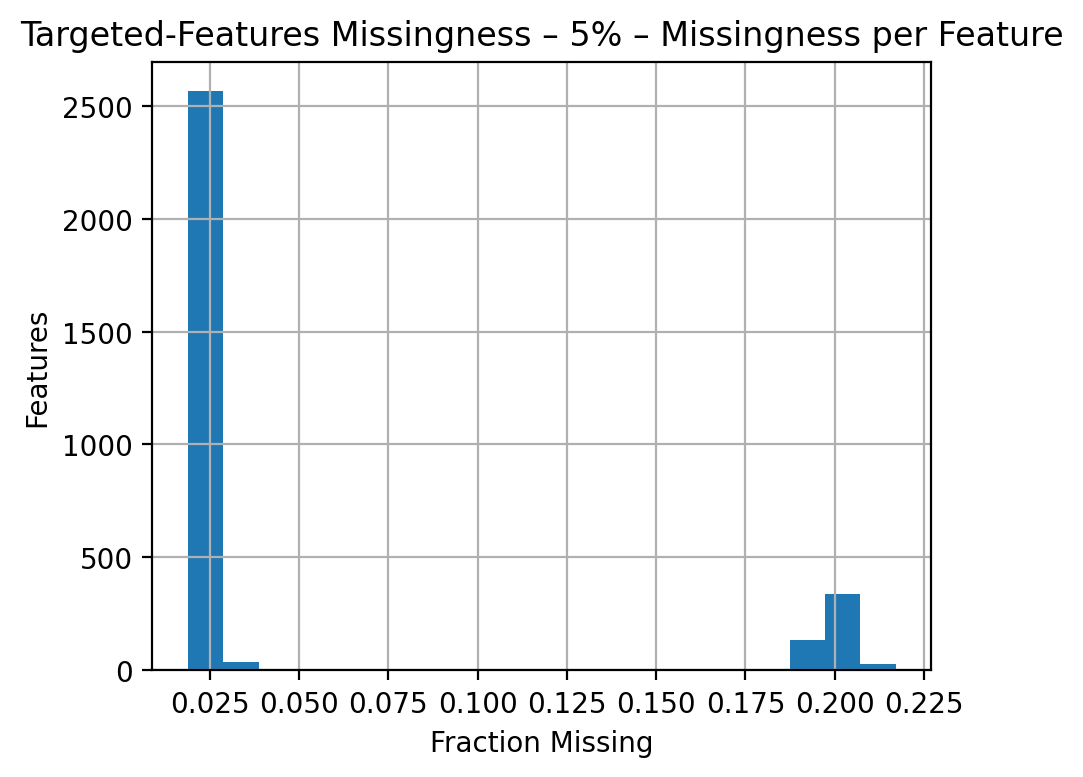


 Random Missingness – 10%


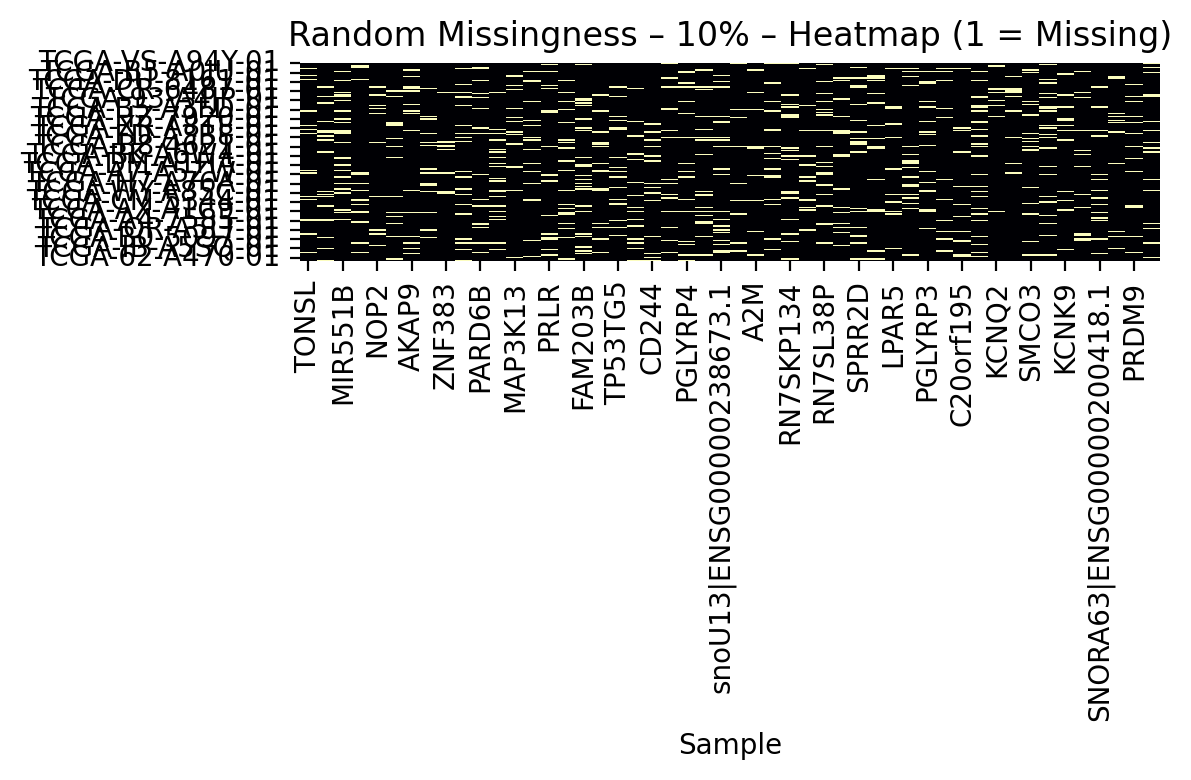

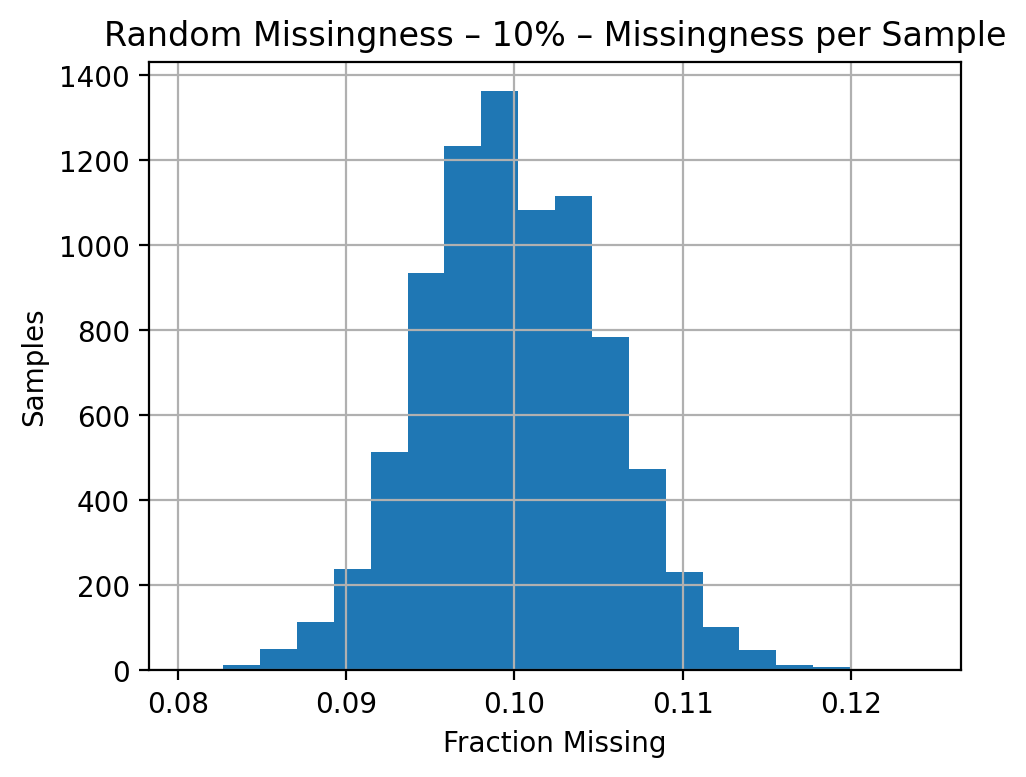

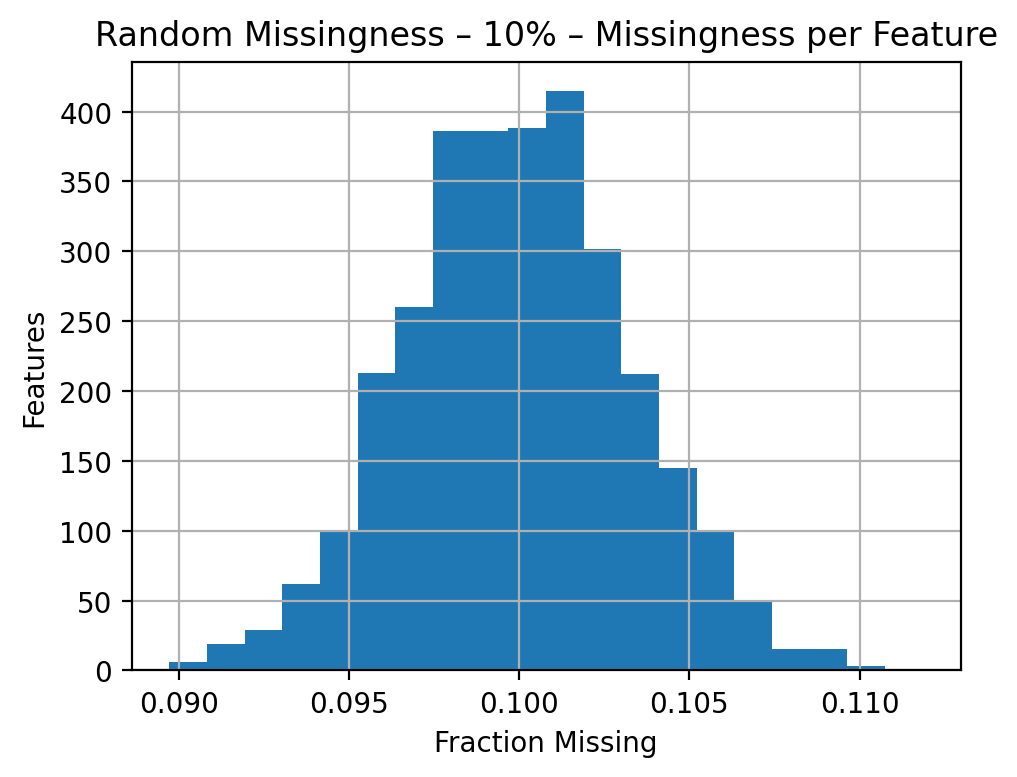


 Targeted-Samples Missingness – 10%


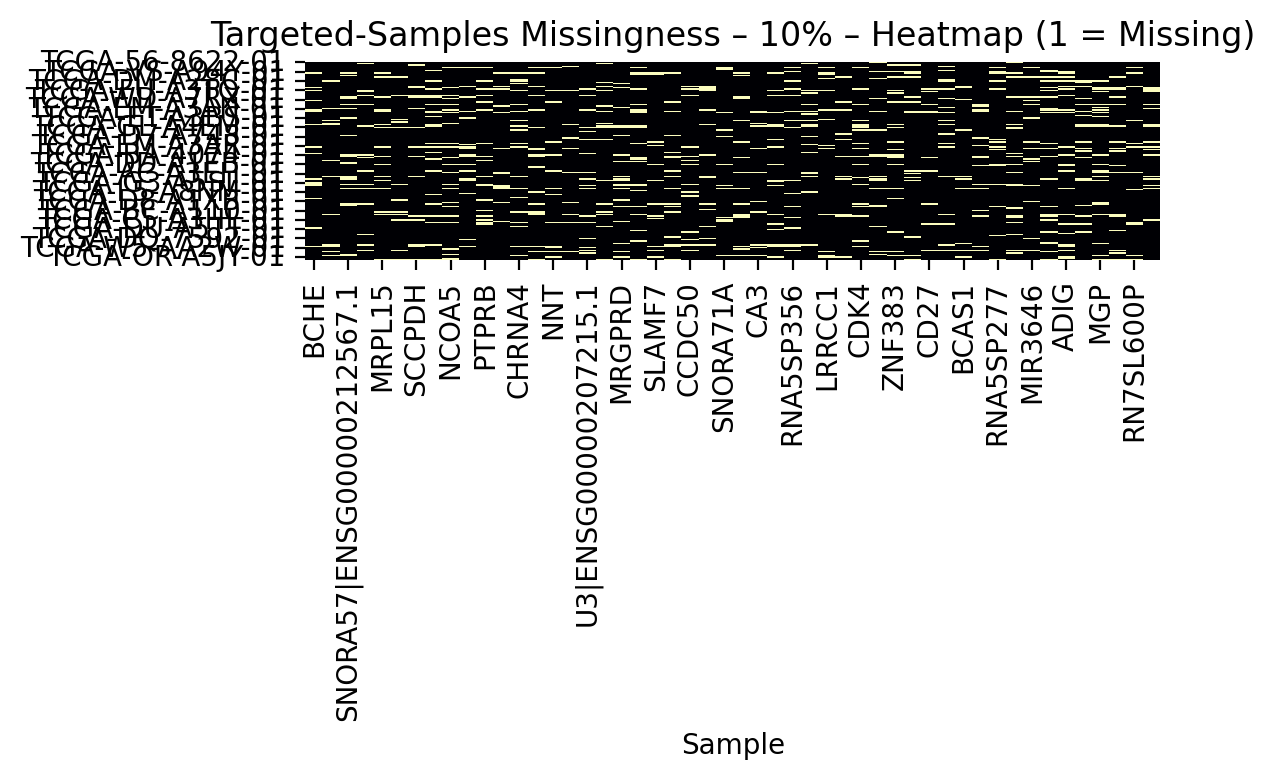

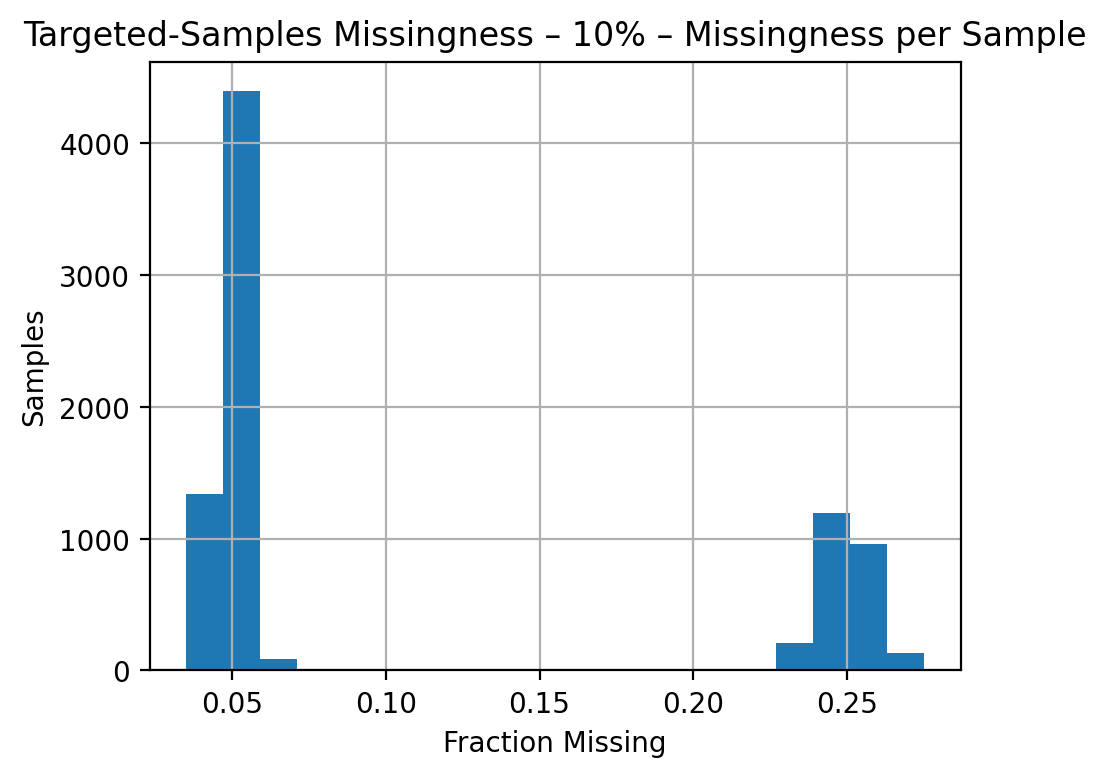

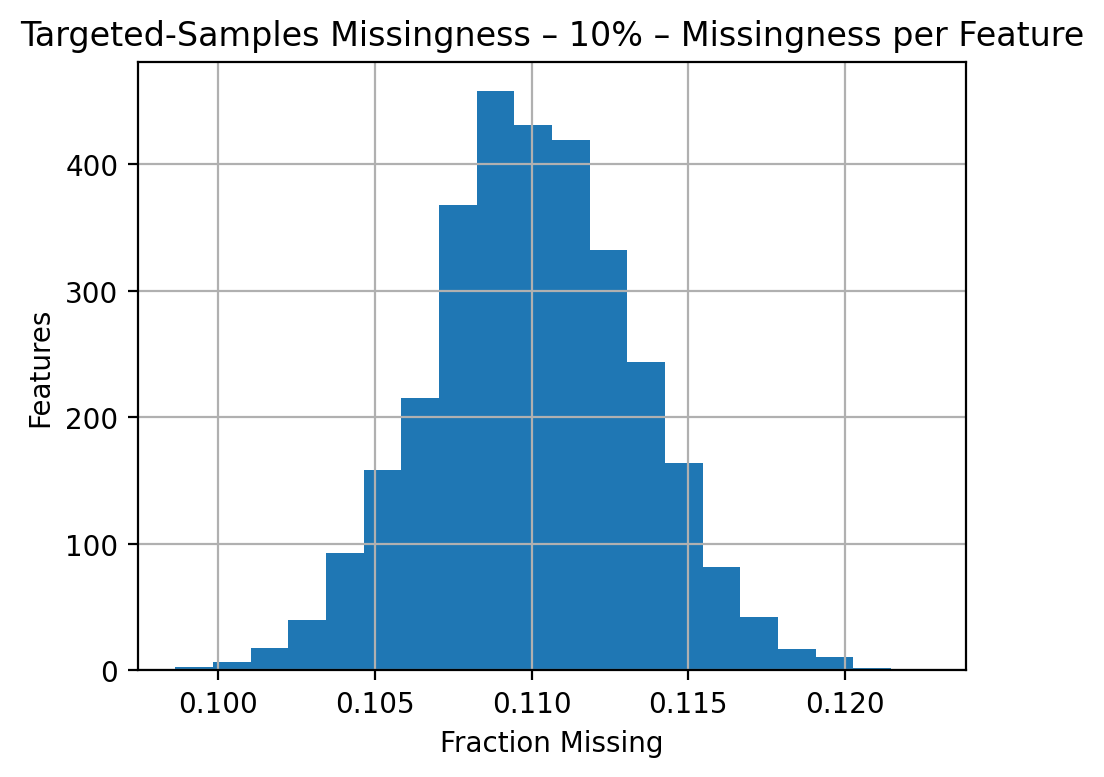


 Targeted-Features Missingness – 10%


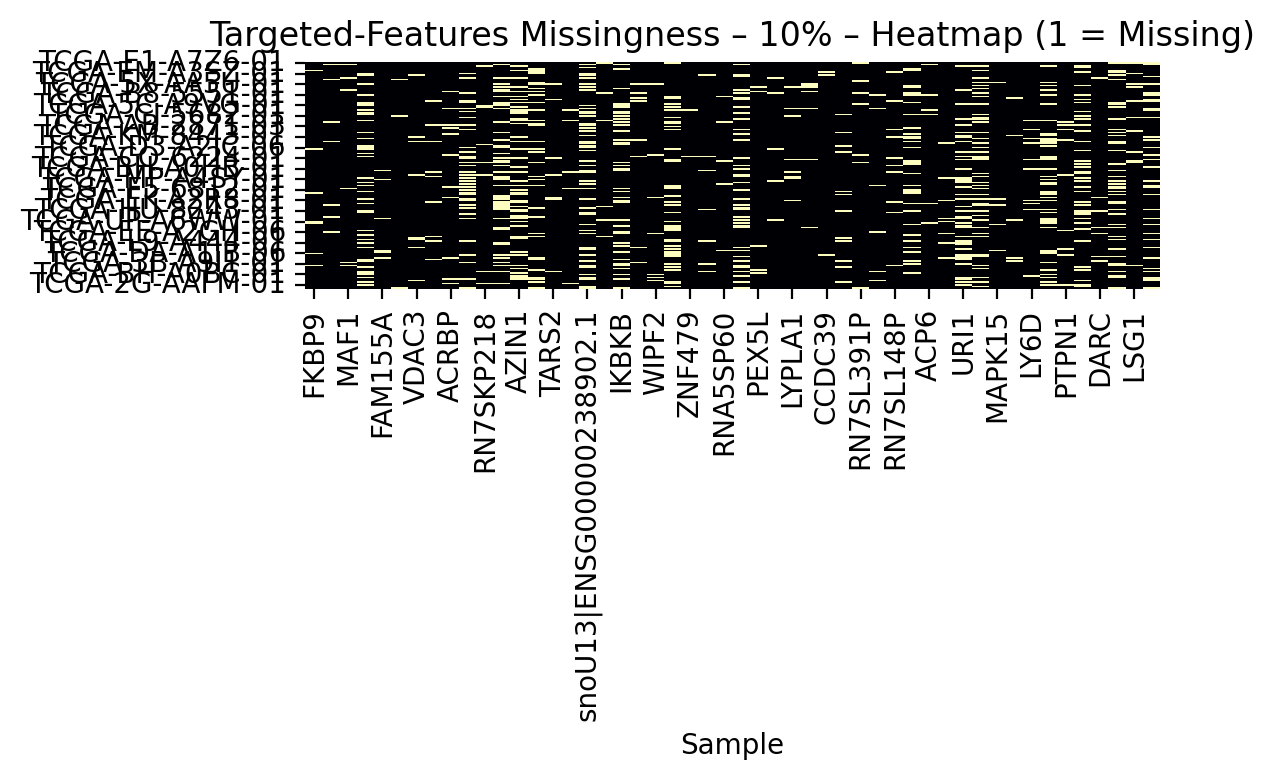

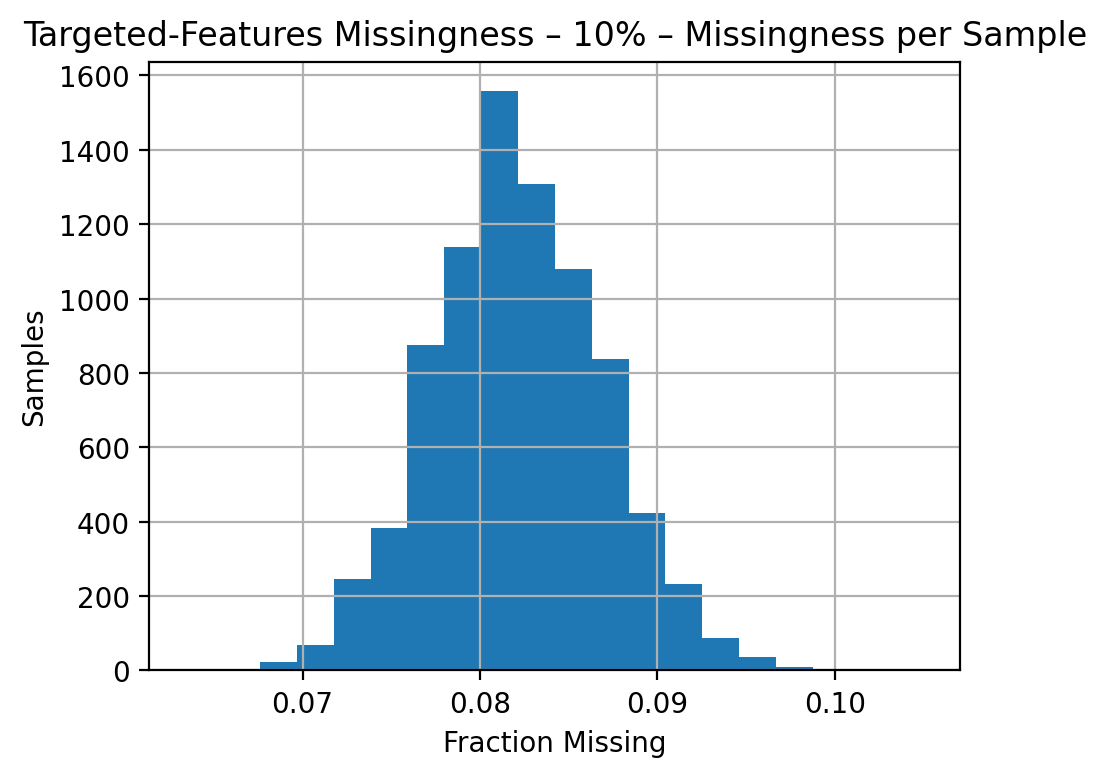

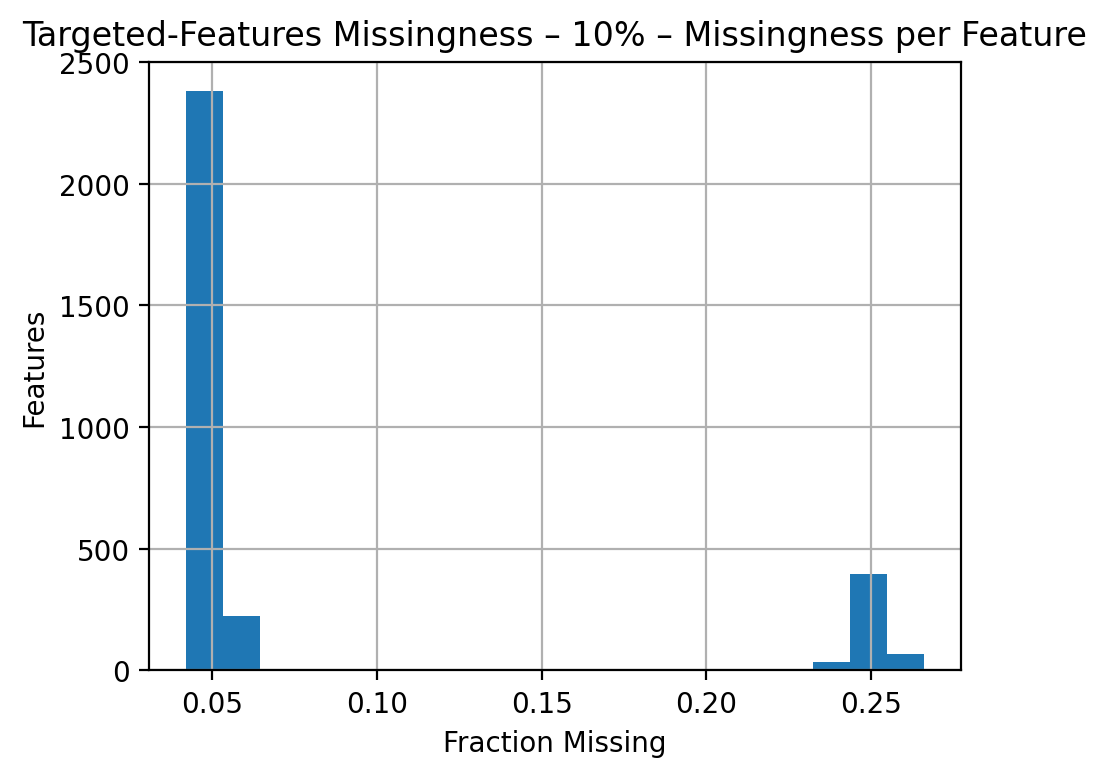


 Random Missingness – 20%


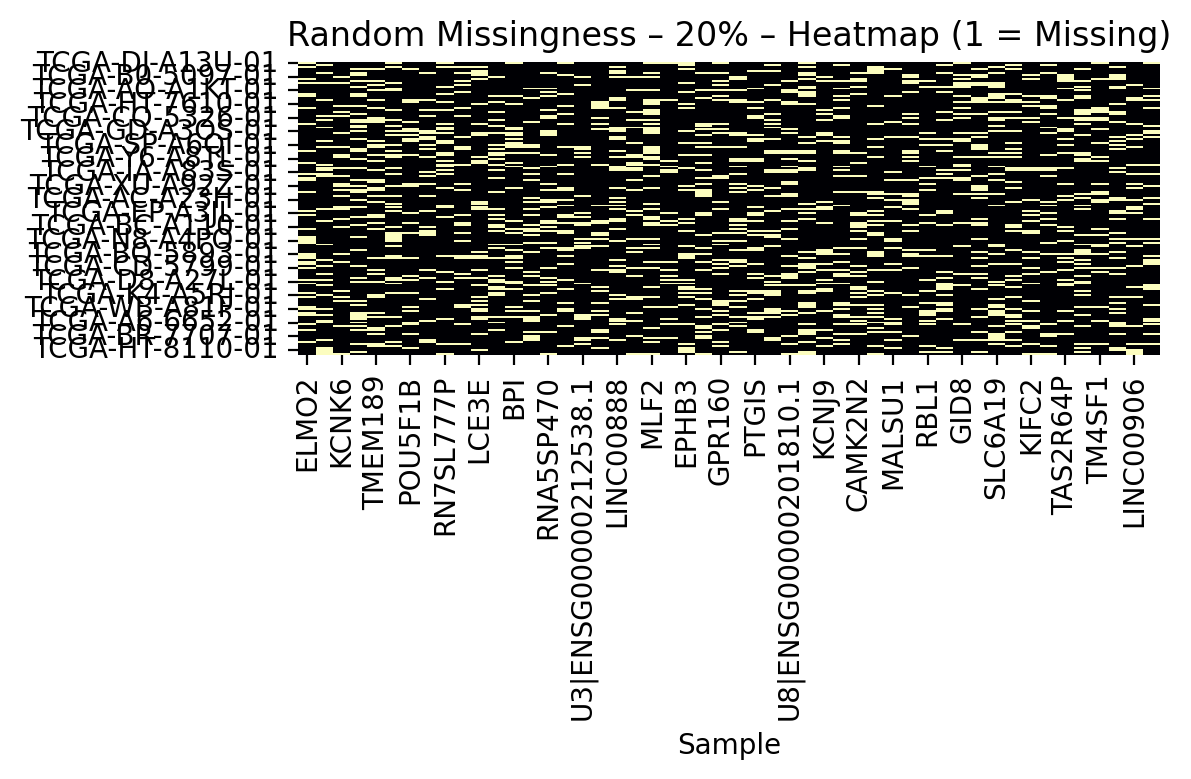

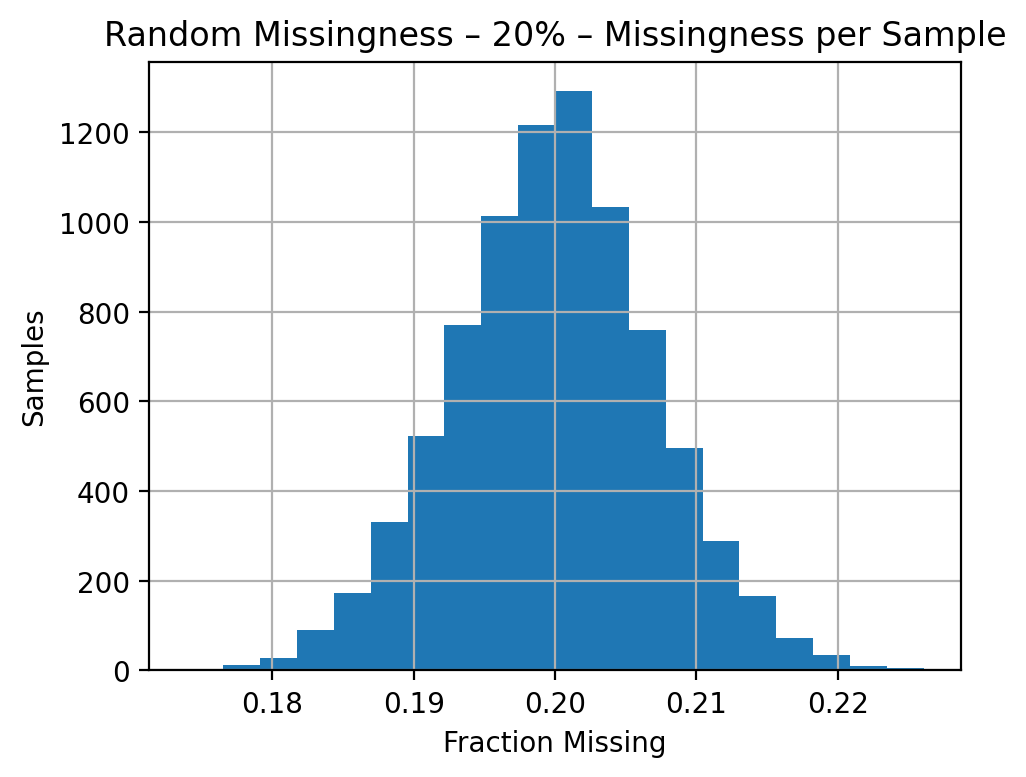

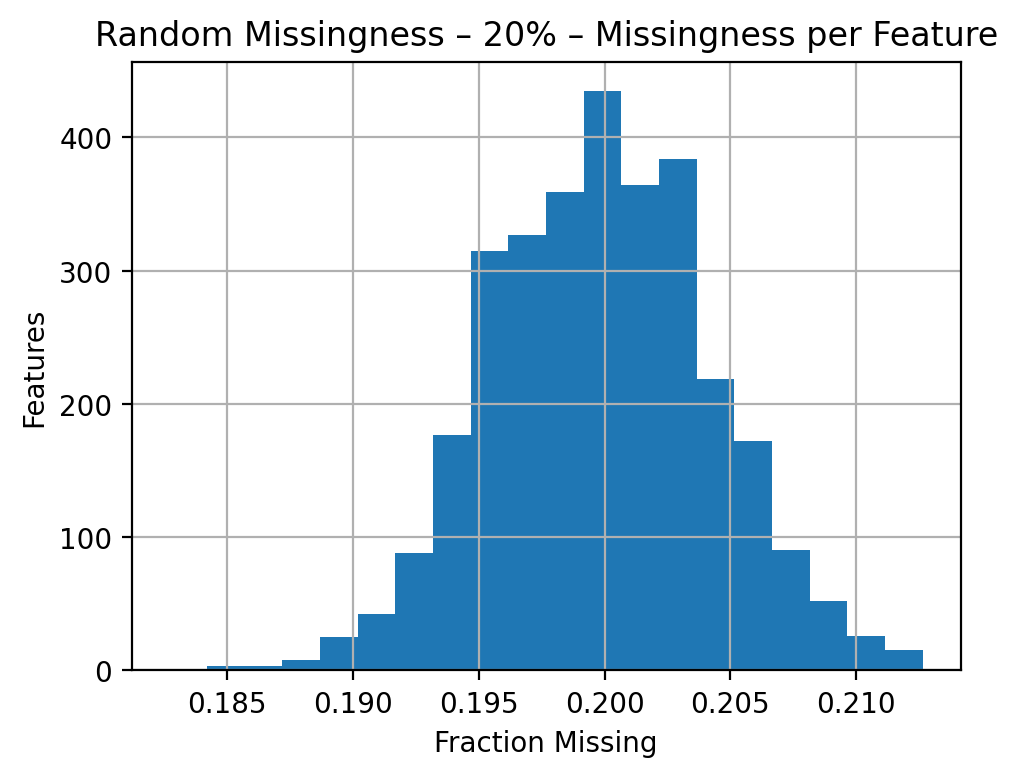


 Targeted-Samples Missingness – 20%


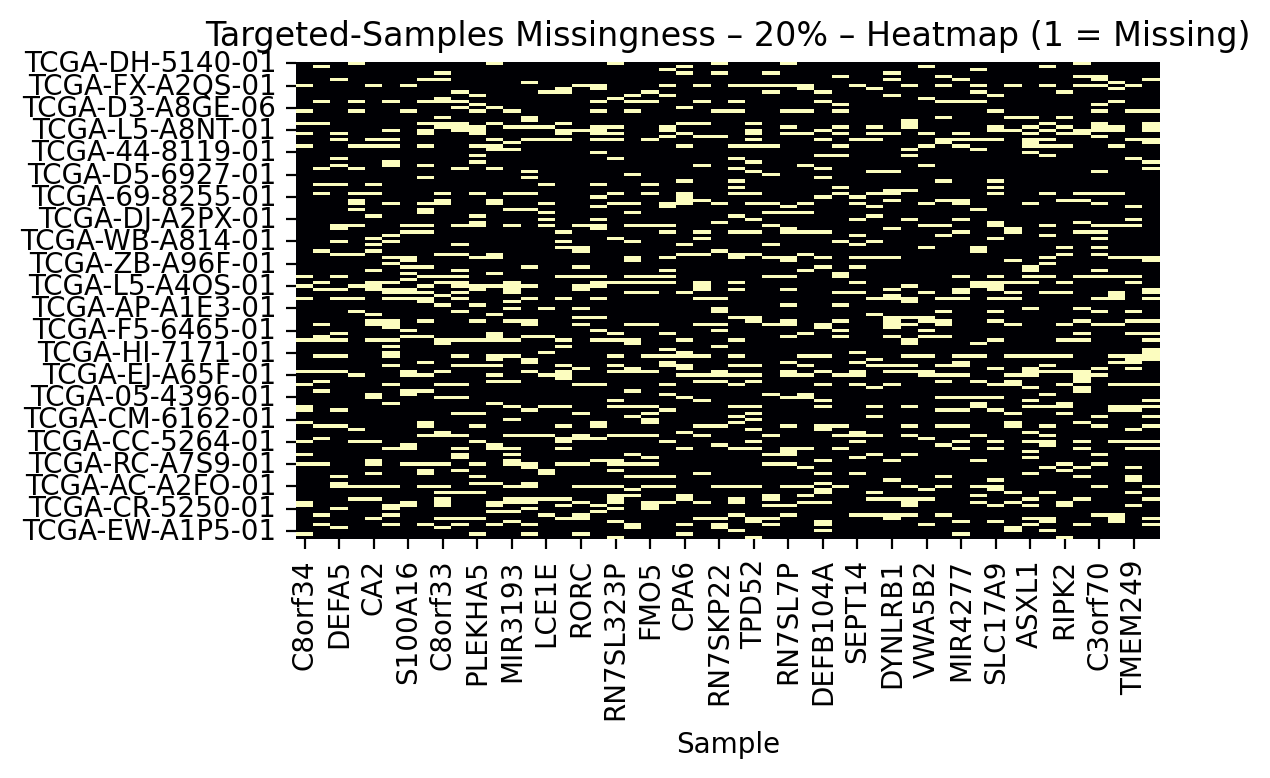

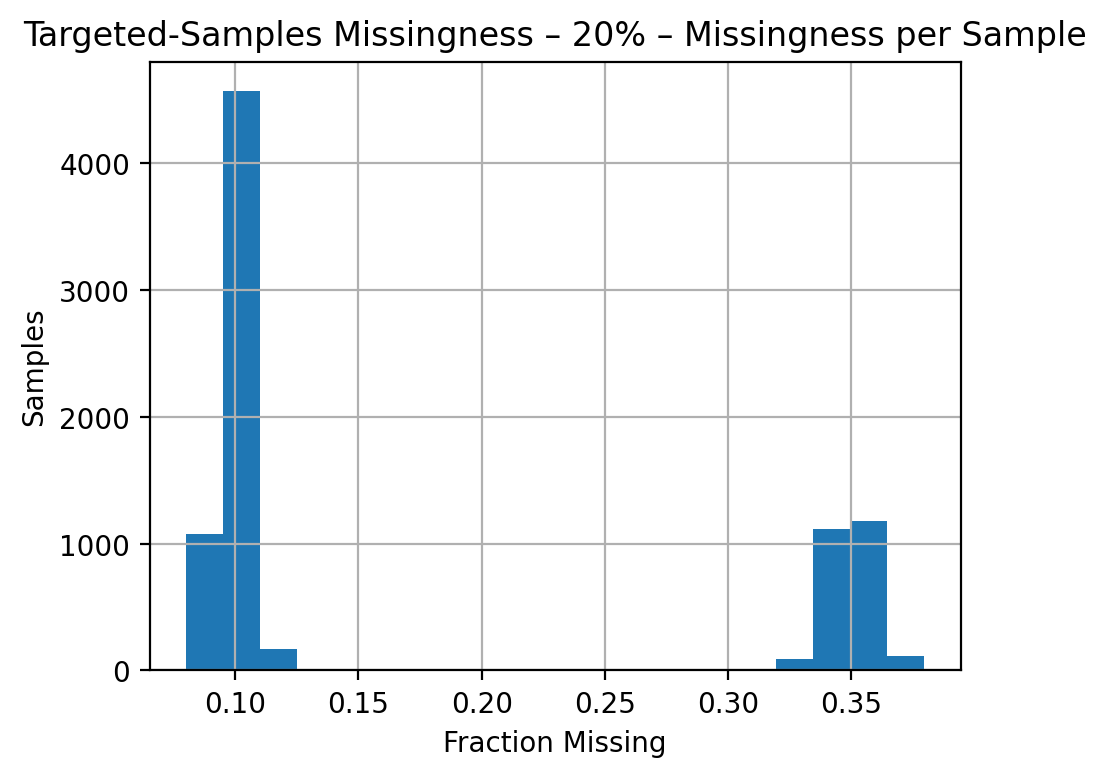

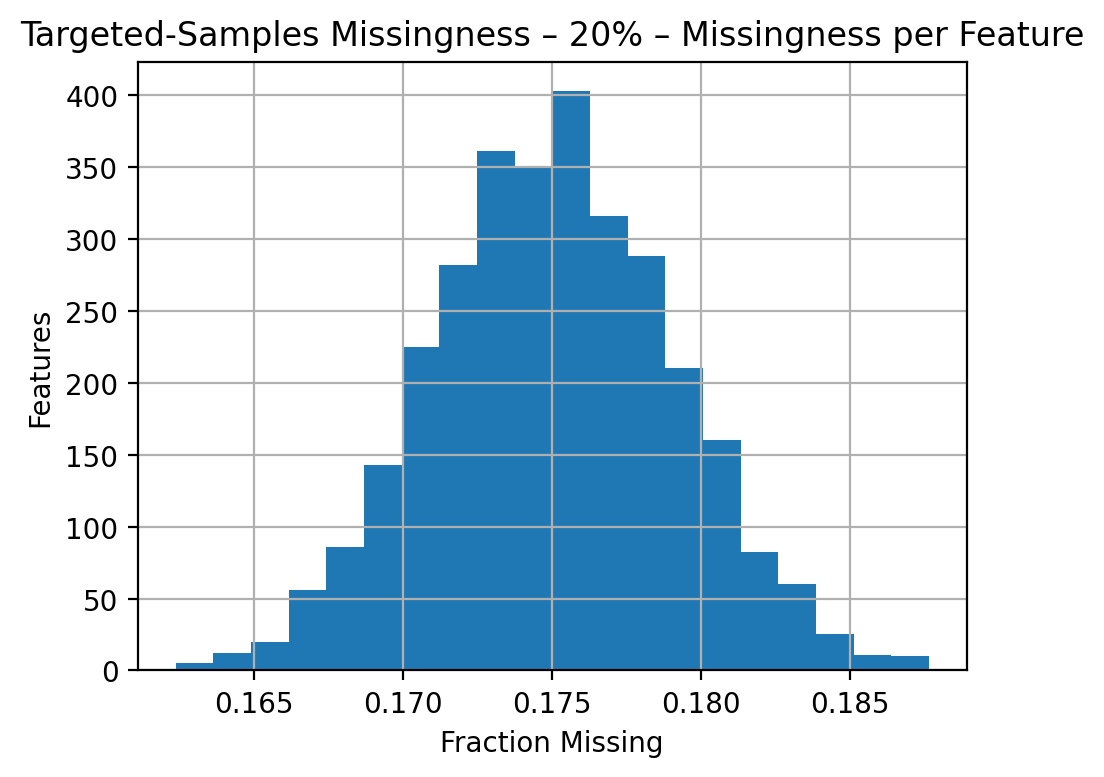


 Targeted-Features Missingness – 20%


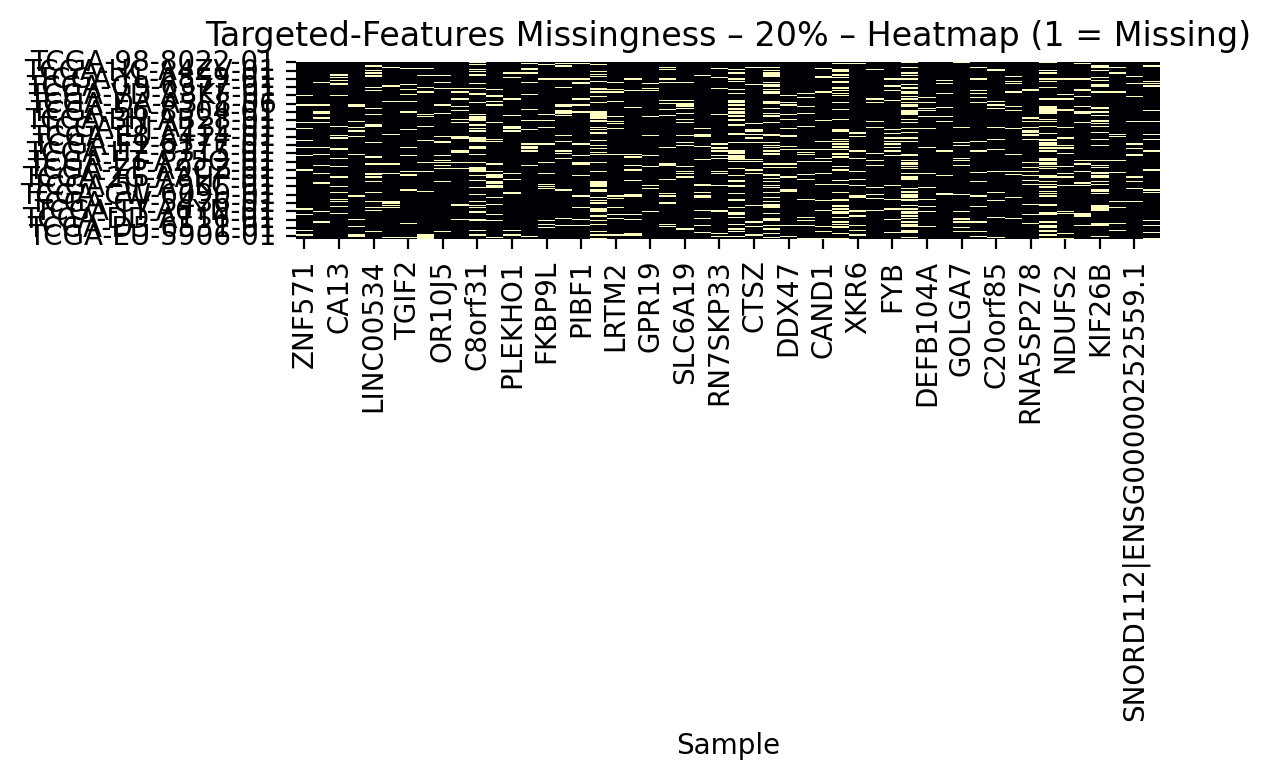

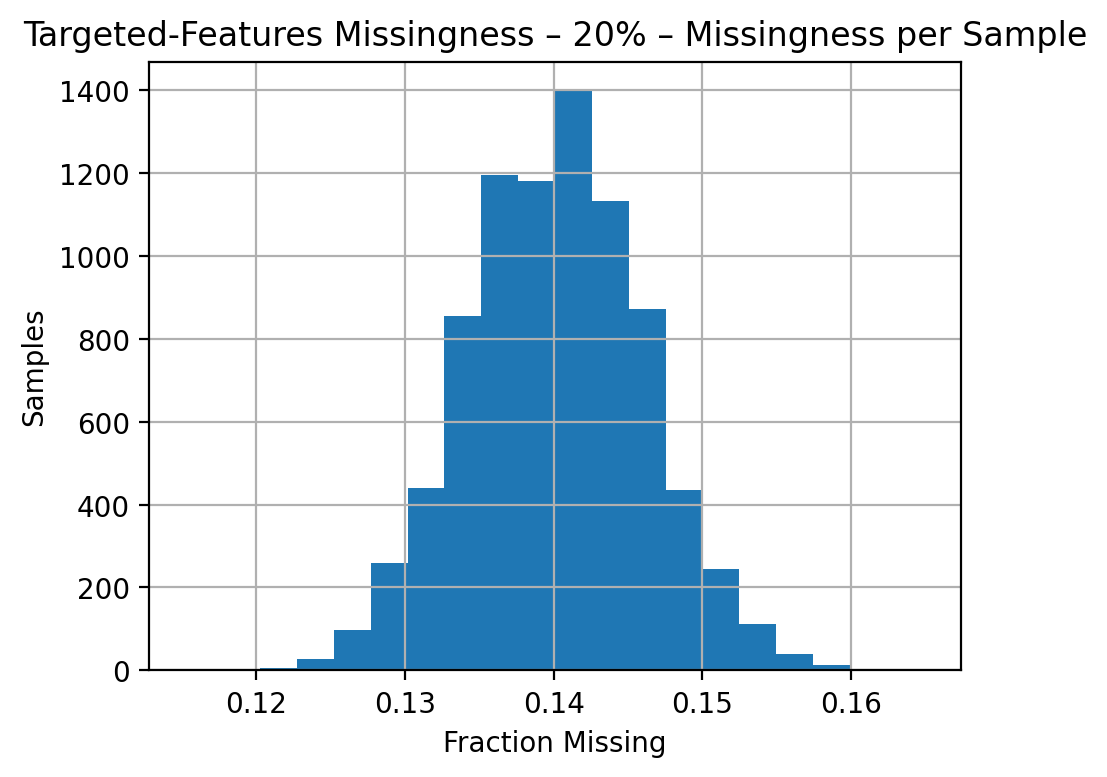

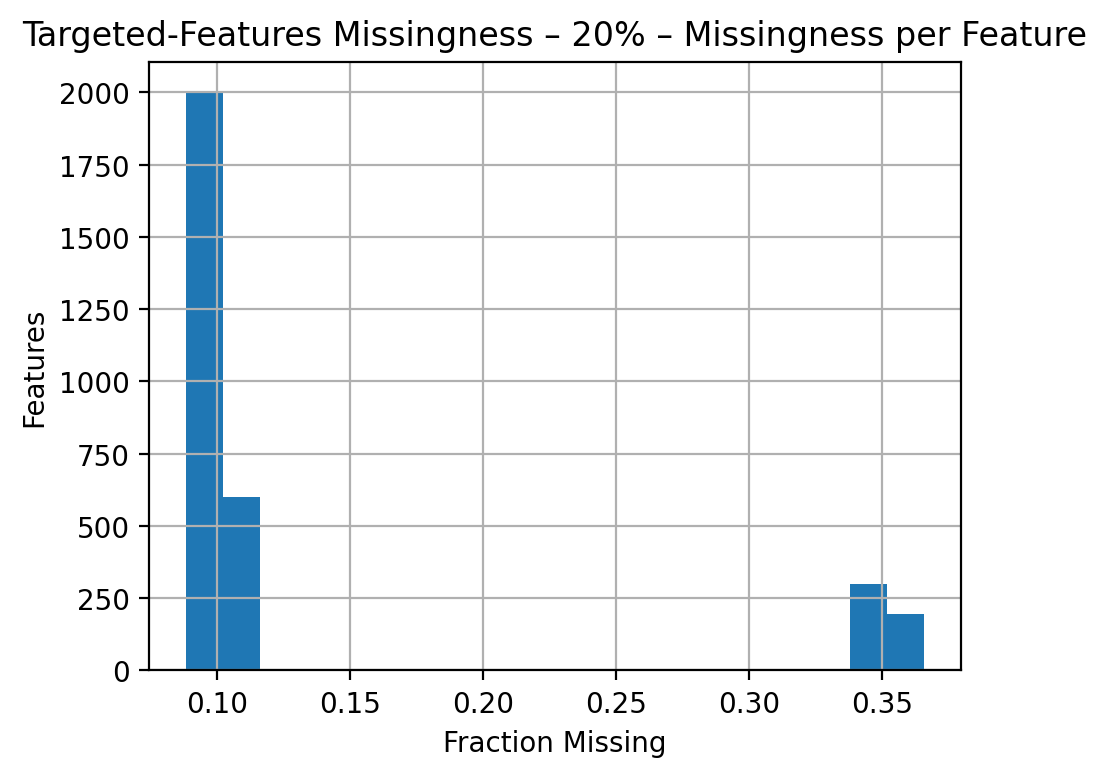


 All missingness graphs displayed successfully.
Masked CNV datasets saved to: /home/jupyter/missingness_versions


In [36]:
# ============================================================================ 
# Step 6: Simulating Missing Omics Data (Jupyter Classic Notebook Version)
# Creates 27 plots:
#   • 3 Missingness Types: Random, Targeted by Samples, Targeted by Features
#   • 3 Missingness Levels (5%, 10%, 20%)
#   • 3 Plots per combination: Heatmap, per-sample, per-feature
# Also saves 9 masked CNV datasets
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Use your CNV scaled dataset
DATA_NAME = "CNV"
DATA_DF = CNV_scaled  # already scaled earlier

# Create folders locally inside the Jupyter environment
save_dir = "/home/jupyter/missingness_plots"
miss_dir = "/home/jupyter/missingness_versions"

os.makedirs(save_dir, exist_ok=True)
os.makedirs(miss_dir, exist_ok=True)


# ---------------------------
# Masking Functions
# ---------------------------
def inject_random_mask(df, p):
    mask = (np.random.rand(*df.shape) >= p).astype(np.int8)
    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)


def inject_targeted_by_samples(df, p, sample_frac=0.3):
    n = df.shape[0]
    sel_n = max(1, int(sample_frac * n))
    selected = np.random.choice(df.index, size=sel_n, replace=False)

    heavy = min(0.95, p + 0.15)
    light = p / 2

    mask = np.ones(df.shape, dtype=np.int8)

    mask[df.index.isin(selected), :] = (
        np.random.rand(sel_n, df.shape[1]) >= heavy
    ).astype(np.int8)

    rest = df.index.difference(selected)
    mask[df.index.get_indexer(rest), :] = (
        np.random.rand(len(rest), df.shape[1]) >= light
    ).astype(np.int8)

    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)


def inject_targeted_by_features(df, p, topk=500):
    var = df.var(axis=0)
    top_feats = var.sort_values(ascending=False).head(min(topk, df.shape[1])).index

    heavy = min(0.95, p + 0.15)
    light = p / 2

    mask = np.ones(df.shape, dtype=np.int8)

    # heavy missingness on top variable features
    mask[:, df.columns.get_indexer(top_feats)] = (
        np.random.rand(df.shape[0], len(top_feats)) >= heavy
    ).astype(np.int8)

    rest = df.columns.difference(top_feats)
    mask[:, df.columns.get_indexer(rest)] = (
        np.random.rand(df.shape[0], len(rest)) >= light
    ).astype(np.int8)

    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)


# ---------------------------
# Display Inline Plots
# ---------------------------
def display_plots(mask_df, missing_type, p):
    title_prefix = f"{missing_type} Missingness – {int(p*100)}%"

    print("\n" + "="*80)
    print(f" {title_prefix}")
    print("="*80)

    # Heatmap of subset
    r = min(150, mask_df.shape[0])
    c = min(50, mask_df.shape[1])
    sub = mask_df.sample(r).sample(c, axis=1)

    plt.figure(figsize=(6, 4))
    sns.heatmap(1 - sub, cmap="magma", cbar=False)
    plt.title(f"{title_prefix} – Heatmap (1 = Missing)")
    plt.tight_layout()
    plt.show()

    # Missingness per sample
    plt.figure(figsize=(5, 4))
    (mask_df == 0).mean(axis=1).hist(bins=20)
    plt.title(f"{title_prefix} – Missingness per Sample")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Samples")
    plt.tight_layout()
    plt.show()

    # Missingness per feature
    plt.figure(figsize=(5, 4))
    (mask_df == 0).mean(axis=0).hist(bins=20)
    plt.title(f"{title_prefix} – Missingness per Feature")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


# ============================================================================ 
# Generate 27 Graphs + Save 9 Missingness Datasets
# ============================================================================

levels = [0.05, 0.10, 0.20]  # 5%, 10%, 20%

for p in levels:

    # 1) Random Missingness
    rnd_masked, rnd_mask = inject_random_mask(DATA_DF, p)
    display_plots(rnd_mask, "Random", p)
    rnd_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_random_{int(p*100)}.parquet"))

    # 2) Targeted by Samples
    ts_masked, ts_mask = inject_targeted_by_samples(DATA_DF, p)
    display_plots(ts_mask, "Targeted-Samples", p)
    ts_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_samples_{int(p*100)}.parquet"))

    # 3) Targeted by Features
    tf_masked, tf_mask = inject_targeted_by_features(DATA_DF, p)
    display_plots(tf_mask, "Targeted-Features", p)
    tf_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_features_{int(p*100)}.parquet"))


print("\nAll missingness graphs displayed successfully.")
print("Masked CNV datasets saved to:", miss_dir)


# Step 7: Baseline Imputations (Mean, KNN, Regression)

In [37]:
# ============================================================================
# STEP 7: BASELINE IMPUTATIONS (Mean, KNN, Regression)
# ============================================================================

import os
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

# ============================================================
# Local paths (DO NOT CHANGE)
# ============================================================

miss_dir = "/home/jupyter/missingness_versions"
imp_dir = "/home/jupyter/baseline_imputations"
os.makedirs(imp_dir, exist_ok=True)

print("Loading masked CNV datasets from:", miss_dir)
print("Saving imputations to:", imp_dir)


# ============================================================
# OPTIMIZATION: Use only top 100 mRNA genes for regression
# ============================================================

top_mrna = mRNA_scaled.var().sort_values(ascending=False).head(100).index
mRNA_reg_np = mRNA_scaled[top_mrna].values

print("Selected top variable mRNA features for regression:", len(top_mrna))


# --------------------------------------------------------------------------
# Helper: Run Mean, KNN, Regression imputations on a masked CNV dataset
# --------------------------------------------------------------------------
def run_imputations(CNV_missing_df, label):

    results = {}
    X = CNV_missing_df.values.copy()

    # ------------------------------------------------------------
    # 1. MEAN IMPUTATION (very fast)
    # ------------------------------------------------------------
    col_means = np.nanmean(X, axis=0)
    mean_imp_np = np.where(np.isnan(X), col_means, X)

    results["mean"] = pd.DataFrame(
        mean_imp_np, index=CNV_missing_df.index, columns=CNV_missing_df.columns
    )


    # ------------------------------------------------------------
    # 2. KNN IMPUTATION (n_neighbors=2 for speed)
    # ------------------------------------------------------------
    knn = KNNImputer(n_neighbors=2)
    knn_imp_np = knn.fit_transform(X)

    results["knn"] = pd.DataFrame(
        knn_imp_np, index=CNV_missing_df.index, columns=CNV_missing_df.columns
    )


    # ------------------------------------------------------------
    # 3. REGRESSION IMPUTATION 
    #    - Only regress first 15 columns
    #    - Only use top 100 mRNA genes
    # ------------------------------------------------------------
    reg = LinearRegression()
    reg_imp = X.copy()

    max_cols = min(15, X.shape[1])  # reduced from 30 → 15

    for col_idx in range(max_cols):

        col_vals = X[:, col_idx]
        mask = np.isnan(col_vals)

        if mask.any():
            reg.fit(mRNA_reg_np[~mask], col_vals[~mask])
            reg_imp[mask, col_idx] = reg.predict(mRNA_reg_np[mask])

    results["regression"] = pd.DataFrame(
        reg_imp, index=CNV_missing_df.index, columns=CNV_missing_df.columns
    )


    # ------------------------------------------------------------
    # SAVE ALL RESULTS (unchanged)
    # ------------------------------------------------------------
    for method, df in results.items():
        out_path = os.path.join(imp_dir, f"{label}_{method}.parquet")
        df.to_parquet(out_path)
        print(f"Saved {method} → {out_path}")

    return results


# ============================================================================
# MAIN LOOP — APPLY IMPUTATIONS TO ALL MISSINGNESS FILES
# ============================================================================
missingness_files = sorted([f for f in os.listdir(miss_dir) if f.endswith(".parquet")])

print("\nFound missingness datasets:", len(missingness_files))

for file in missingness_files:

    print("\n" + "="*70)
    print("Processing:", file)
    print("="*70)

    df = pd.read_parquet(os.path.join(miss_dir, file))
    run_imputations(df, file.replace(".parquet", ""))


print("\nAll baseline imputations completed!")
print("Saved in:", imp_dir)


Loading masked CNV datasets from: /home/jupyter/missingness_versions
Saving imputations to: /home/jupyter/baseline_imputations
Selected top variable mRNA features for regression: 100

Found missingness datasets: 9

Processing: CNV_missing_features_10.parquet
Saved mean → /home/jupyter/baseline_imputations/CNV_missing_features_10_mean.parquet
Saved knn → /home/jupyter/baseline_imputations/CNV_missing_features_10_knn.parquet
Saved regression → /home/jupyter/baseline_imputations/CNV_missing_features_10_regression.parquet

Processing: CNV_missing_features_20.parquet
Saved mean → /home/jupyter/baseline_imputations/CNV_missing_features_20_mean.parquet
Saved knn → /home/jupyter/baseline_imputations/CNV_missing_features_20_knn.parquet
Saved regression → /home/jupyter/baseline_imputations/CNV_missing_features_20_regression.parquet

Processing: CNV_missing_features_5.parquet
Saved mean → /home/jupyter/baseline_imputations/CNV_missing_features_5_mean.parquet
Saved knn → /home/jupyter/baseline_imp

# Step 8: Autoencoder Model for Generative Imputation

In [38]:
# ============================================================================
# STEP 8: Autoencoder (MLP) for Generative Imputation
# ============================================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# ============================================================
# Paths
# ============================================================

miss_dir = "/home/jupyter/missingness_versions"       # masked CNV datasets
ae_dir   = "/home/jupyter/autoencoder_imputations"    # save AE outputs here
os.makedirs(ae_dir, exist_ok=True)

print("Using missingness files from:", miss_dir)
print("Saving autoencoder imputations to:", ae_dir)


# ============================================================
# DEVICE SETUP (GPU if available)
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


# ============================================================
# Autoencoder (MLP) Model
# ============================================================

class MLPImputer(nn.Module):
    def __init__(self, in_dim, out_dim, h=512, bottleneck=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(),
            nn.Linear(h, bottleneck), nn.ReLU(),
            nn.Linear(bottleneck, h), nn.ReLU(),
            nn.Linear(h, out_dim)
        )
    def forward(self, x):
        return self.net(x)


# Input sizes
in_dim  = mRNA_scaled.shape[1]
out_dim = CNV_scaled.shape[1]

model = MLPImputer(in_dim, out_dim).to(DEVICE)


# ============================================================
# Prepare Training Data
# ============================================================

X = torch.tensor(mRNA_scaled.values, dtype=torch.float32)
Y = torch.tensor(CNV_scaled.values,  dtype=torch.float32)

ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=128, shuffle=True)


# ============================================================
# Training Setup
# ============================================================

optim_ = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 10  # increase to 25 or 50 if you want better reconstruction


# ============================================================
# Train the Autoencoder
# ============================================================

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0

    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optim_.zero_grad()
        loss.backward()
        optim_.step()

        total += loss.item() * xb.size(0)

    print(f"Epoch {epoch}/{EPOCHS} | Train MSE: {total/len(ds):.6f}")


# ============================================================
# Predict CNV for *all* samples (full reconstruction)
# ============================================================

model.eval()
with torch.no_grad():
    CNV_pred_all = model(
        torch.tensor(mRNA_scaled.values, dtype=torch.float32, device=DEVICE)
    ).cpu().numpy()

CNV_pred_df = pd.DataFrame(
    CNV_pred_all, index=mRNA_scaled.index, columns=CNV_scaled.columns
)


# ============================================================
# Impute each masked CNV dataset using the AE predictions
# ============================================================

miss_files = sorted([f for f in os.listdir(miss_dir) if f.endswith(".parquet")])

for file in miss_files:

    label = file.replace(".parquet", "")
    CNV_missing_df = pd.read_parquet(os.path.join(miss_dir, file))

    filled = CNV_missing_df.copy()
    na_locs = filled.isna()

    # fill NaNs only
    filled[na_locs] = CNV_pred_df[na_locs]

    # safety fallback (should rarely run)
    filled = filled.fillna(filled.mean())

    out_path = os.path.join(ae_dir, f"{label}_mlpAE.parquet")
    filled.to_parquet(out_path)

    print("Saved:", out_path)

print("\nAutoencoder imputation completed!")
print("Files saved to:", ae_dir)


Using missingness files from: /home/jupyter/missingness_versions
Saving autoencoder imputations to: /home/jupyter/autoencoder_imputations
Using device: cpu
Epoch 1/10 | Train MSE: 0.783051
Epoch 2/10 | Train MSE: 0.594533
Epoch 3/10 | Train MSE: 0.504107
Epoch 4/10 | Train MSE: 0.451577
Epoch 5/10 | Train MSE: 0.404590
Epoch 6/10 | Train MSE: 0.368452
Epoch 7/10 | Train MSE: 0.343700
Epoch 8/10 | Train MSE: 0.318846
Epoch 9/10 | Train MSE: 0.298678
Epoch 10/10 | Train MSE: 0.283793
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_features_10_mlpAE.parquet
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_features_20_mlpAE.parquet
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_features_5_mlpAE.parquet
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_random_10_mlpAE.parquet
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_random_20_mlpAE.parquet
Saved: /home/jupyter/autoencoder_imputations/CNV_missing_random_5_mlpAE.parquet
Saved: /home/jupyter/au

# Step 9: Evaluation Metrics for All Imputation Methods

In [40]:
# ============================================================================
# STEP 9: Evaluation Metrics for All Imputation Methods (SAFE VERSION)
# Handles NaNs properly before metric calculations.
# ============================================================================

import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

MISSING_DIR = "/home/jupyter/missingness_versions"
BASELINE_DIR = "/home/jupyter/baseline_imputations"
AE_DIR = "/home/jupyter/autoencoder_imputations"

true_CNV = CNV_scaled.copy()

def masked_corr(a, b):
    if len(a) < 3:
        return np.nan
    return pearsonr(a, b)[0]

missing_files = sorted([f for f in os.listdir(MISSING_DIR) if f.endswith(".parquet")])
results = []

print("Evaluating", len(missing_files), "missingness datasets...")

for file in missing_files:

    label = file.replace(".parquet", "")
    print("\n---------------------------------------------------------")
    print("Evaluating:", label)
    print("---------------------------------------------------------")

    missing_df = pd.read_parquet(os.path.join(MISSING_DIR, file))
    mask = missing_df.isna().values
    y_true = true_CNV.values[mask]

    methods = ["mean", "knn", "regression", "mlpAE"]

    for method in methods:

        if method == "mlpAE":
            imp_path = os.path.join(AE_DIR, f"{label}_{method}.parquet")
        else:
            imp_path = os.path.join(BASELINE_DIR, f"{label}_{method}.parquet")

        if not os.path.exists(imp_path):
            print("Missing:", imp_path)
            continue

        imp_df = pd.read_parquet(imp_path)

        # -------- FIX: Remove ALL NaNs before metric calculations --------
        imp_df = imp_df.fillna(imp_df.mean())

        y_pred = imp_df.values[mask]

        # Now safe to compute metrics
        mse = mean_squared_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        corr = masked_corr(y_true, y_pred)

        results.append({
            "Missingness": label,
            "Method": method,
            "MSE": mse,
            "R2": r2,
            "Correlation": corr
        })

results_df = pd.DataFrame(results)

print("\nEvaluation complete!")
results_df

Evaluating 9 missingness datasets...

---------------------------------------------------------
Evaluating: CNV_missing_features_10
---------------------------------------------------------

---------------------------------------------------------
Evaluating: CNV_missing_features_20
---------------------------------------------------------

---------------------------------------------------------
Evaluating: CNV_missing_features_5
---------------------------------------------------------

---------------------------------------------------------
Evaluating: CNV_missing_random_10
---------------------------------------------------------

---------------------------------------------------------
Evaluating: CNV_missing_random_20
---------------------------------------------------------

---------------------------------------------------------
Evaluating: CNV_missing_random_5
---------------------------------------------------------

----------------------------------------------------

Missingness      Method       MSE        R2  Correlation
0   CNV_missing_features_10        mean  0.997387 -0.000265    -0.025261
1   CNV_missing_features_10         knn  0.311469  0.687632     0.832159
2   CNV_missing_features_10  regression  0.996947  0.000177     0.016147
3   CNV_missing_features_10       mlpAE  0.265208  0.734027     0.857007
4   CNV_missing_features_20        mean  1.005414 -0.000287    -0.021030
5   CNV_missing_features_20         knn  0.318485  0.683139     0.829545
6   CNV_missing_features_20  regression  1.004865  0.000259     0.017880
7   CNV_missing_features_20       mlpAE  0.269328  0.732045     0.855894
8    CNV_missing_features_5        mean  1.001566 -0.000262    -0.027276
9    CNV_missing_features_5         knn  0.311903  0.688502     0.832718
10   CNV_missing_features_5  regression  1.001106  0.000197     0.016197
11   CNV_missing_features_5       mlpAE  0.266429  0.733918     0.856932
12    CNV_missing_random_10        mean  1.001559 -0.000250    -0.032622
13    CNV_missing_random_10         knn  0.312648  0.687760     0.831969
14    CNV_missing_random_10  regression  1.001030  0.000277     0.018635
15    CNV_missing_random_10       mlpAE  0.269073  0.731279     0.855442
16    CNV_missing_random_20        mean  1.000086 -0.000249    -0.021047
17    CNV_missing_random_20         knn  0.320377  0.679571     0.827186
18    CNV_missing_random_20  regression  0.999522  0.000315     0.019549
19    CNV_missing_random_20       mlpAE  0.270230  0.729726     0.854538
20     CNV_missing_random_5        mean  1.001019 -0.000255    -0.048534
21     CNV_missing_random_5         knn  0.311141  0.689096     0.832707
22     CNV_missing_random_5  regression  1.000373  0.000391     0.020646
23     CNV_missing_random_5       mlpAE  0.272201  0.728007     0.853532
24   CNV_missing_samples_10        mean  0.988563 -0.000265    -0.030349
25   CNV_missing_samples_10         knn  0.314916  0.681357     0.828250
26   CNV_missing_samples_10  regression  0.987917  0.000388     0.021237
27   CNV_missing_samples_10       mlpAE  0.271676  0.725108     0.851865
28   CNV_missing_samples_20        mean  1.000544 -0.000294    -0.023328
29   CNV_missing_samples_20         knn  0.320668  0.679412     0.827122
30   CNV_missing_samples_20  regression  0.999988  0.000263     0.019334
31   CNV_missing_samples_20       mlpAE  0.270274  0.729793     0.854589
32    CNV_missing_samples_5        mean  0.984369 -0.000273    -0.038199
33    CNV_missing_samples_5         knn  0.310142  0.684847     0.830173
34    CNV_missing_samples_5  regression  0.983737  0.000369     0.020690
35    CNV_missing_samples_5       mlpAE  0.268302  0.727363     0.853128

# Step 9.1 : Plot Imputation Performance (Grouped Bar Charts)

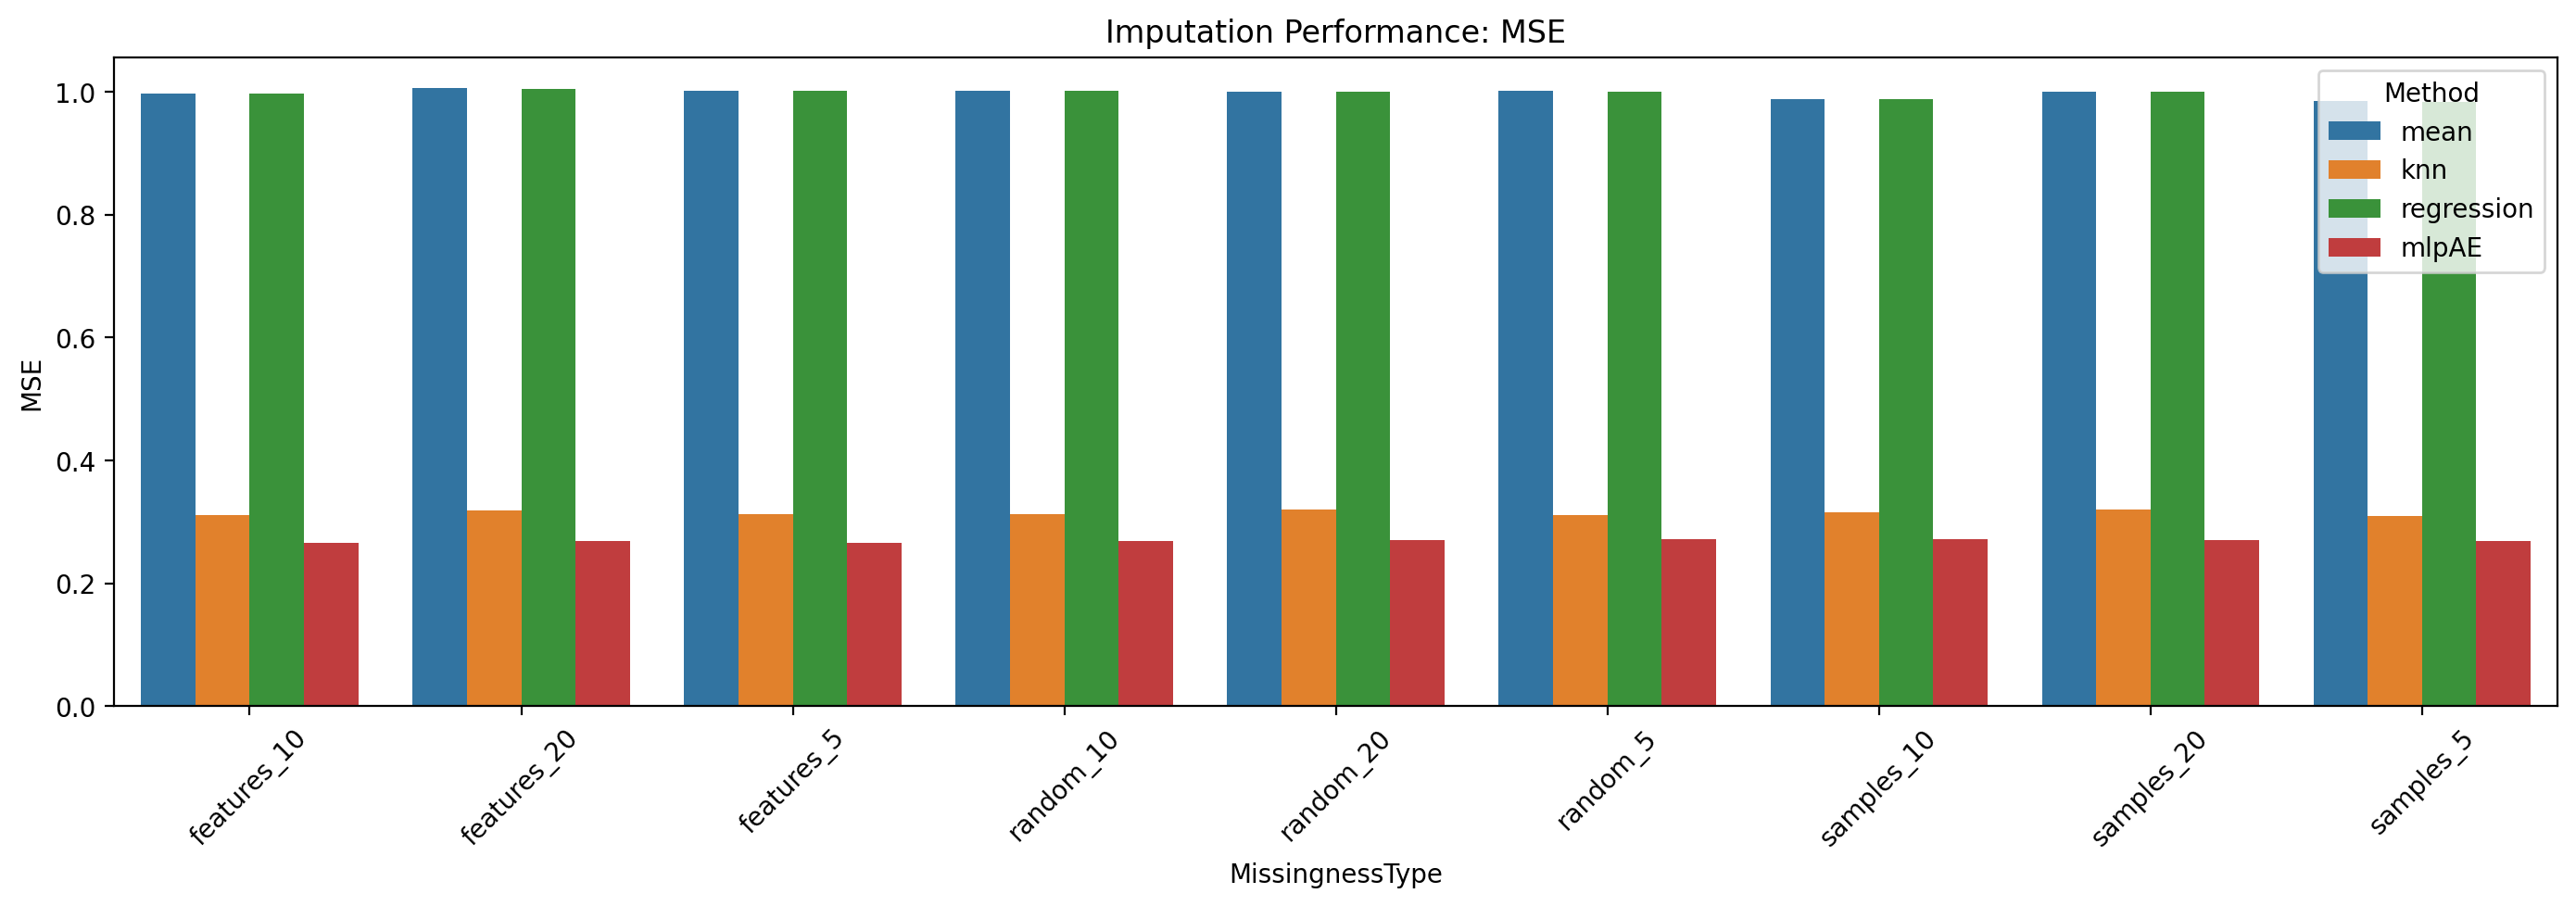

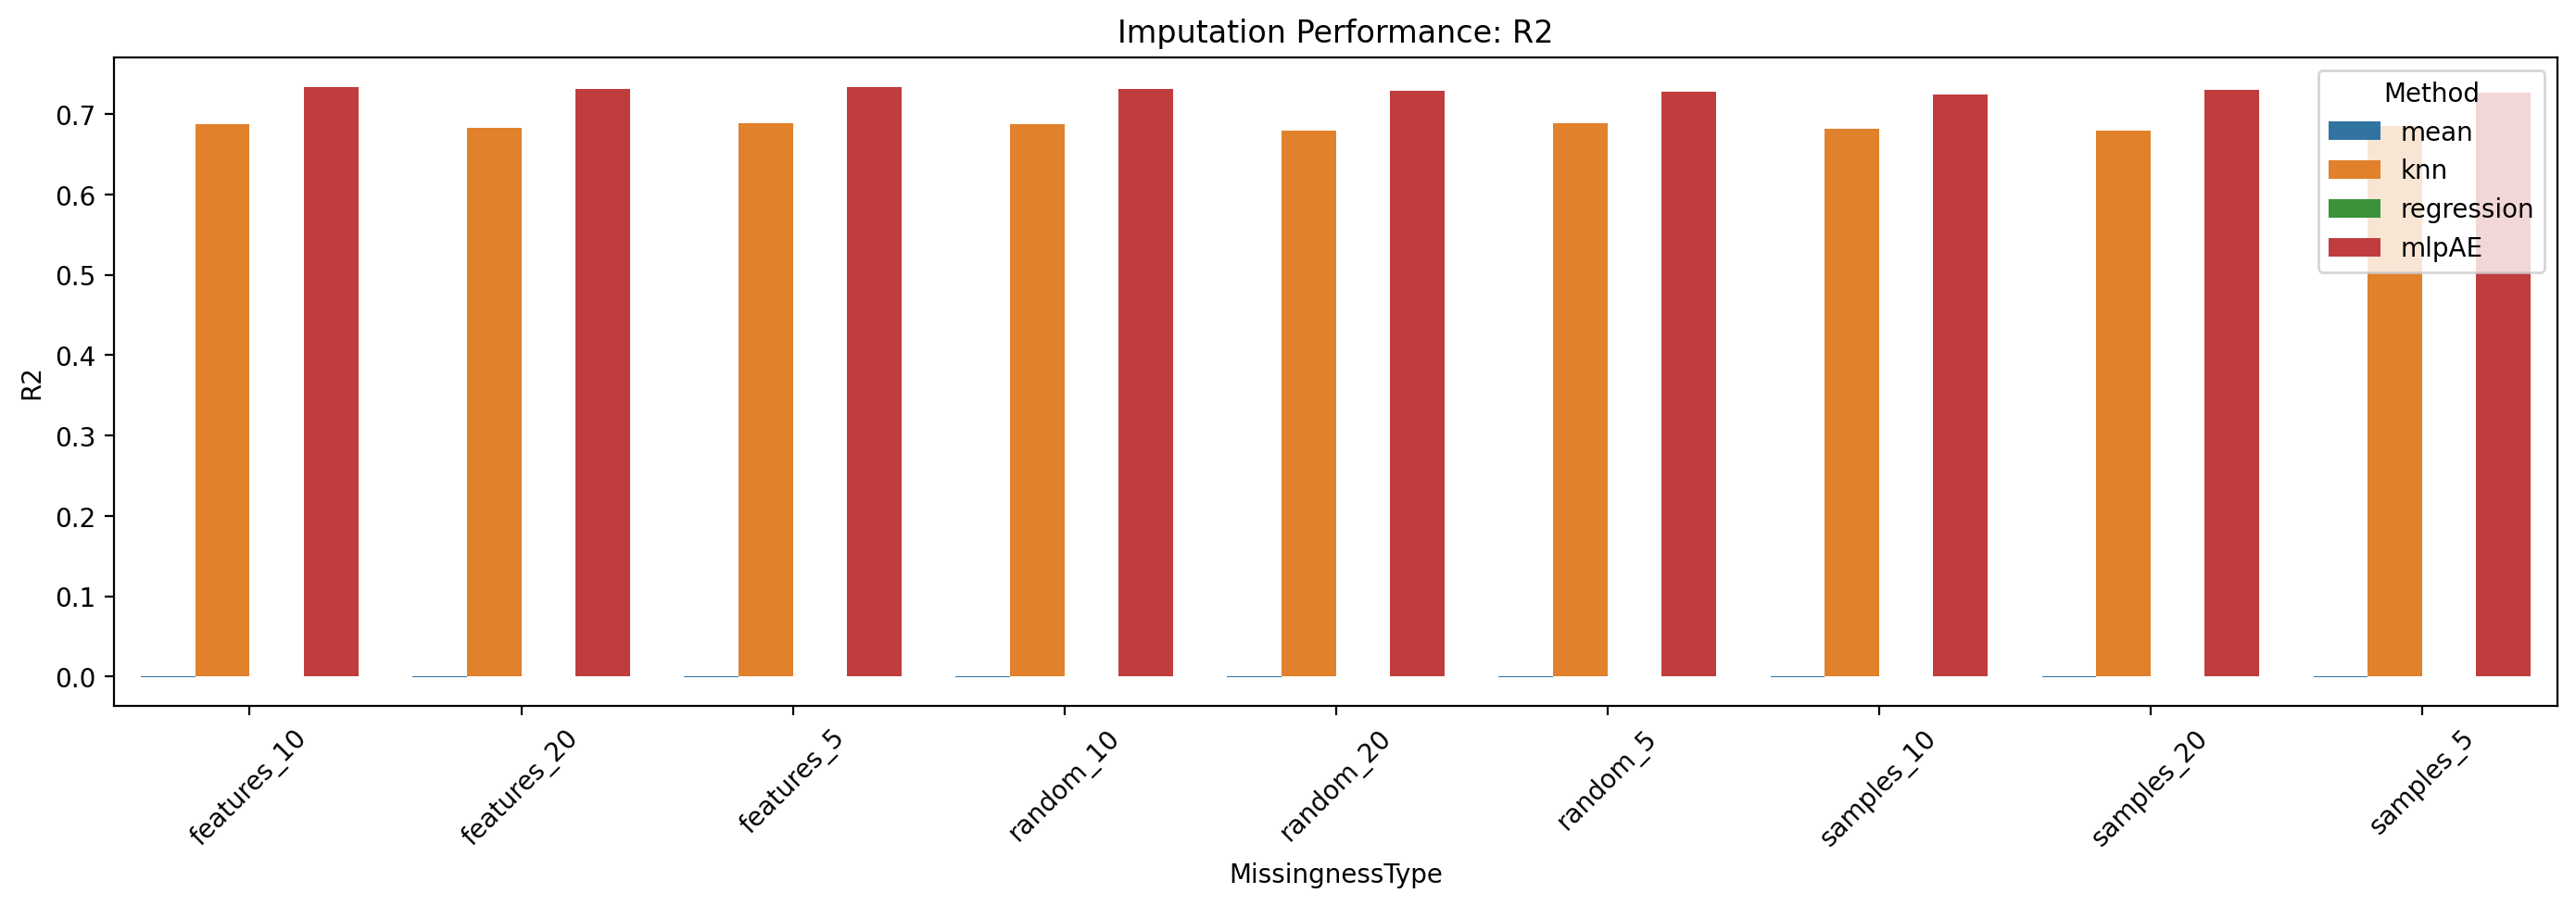

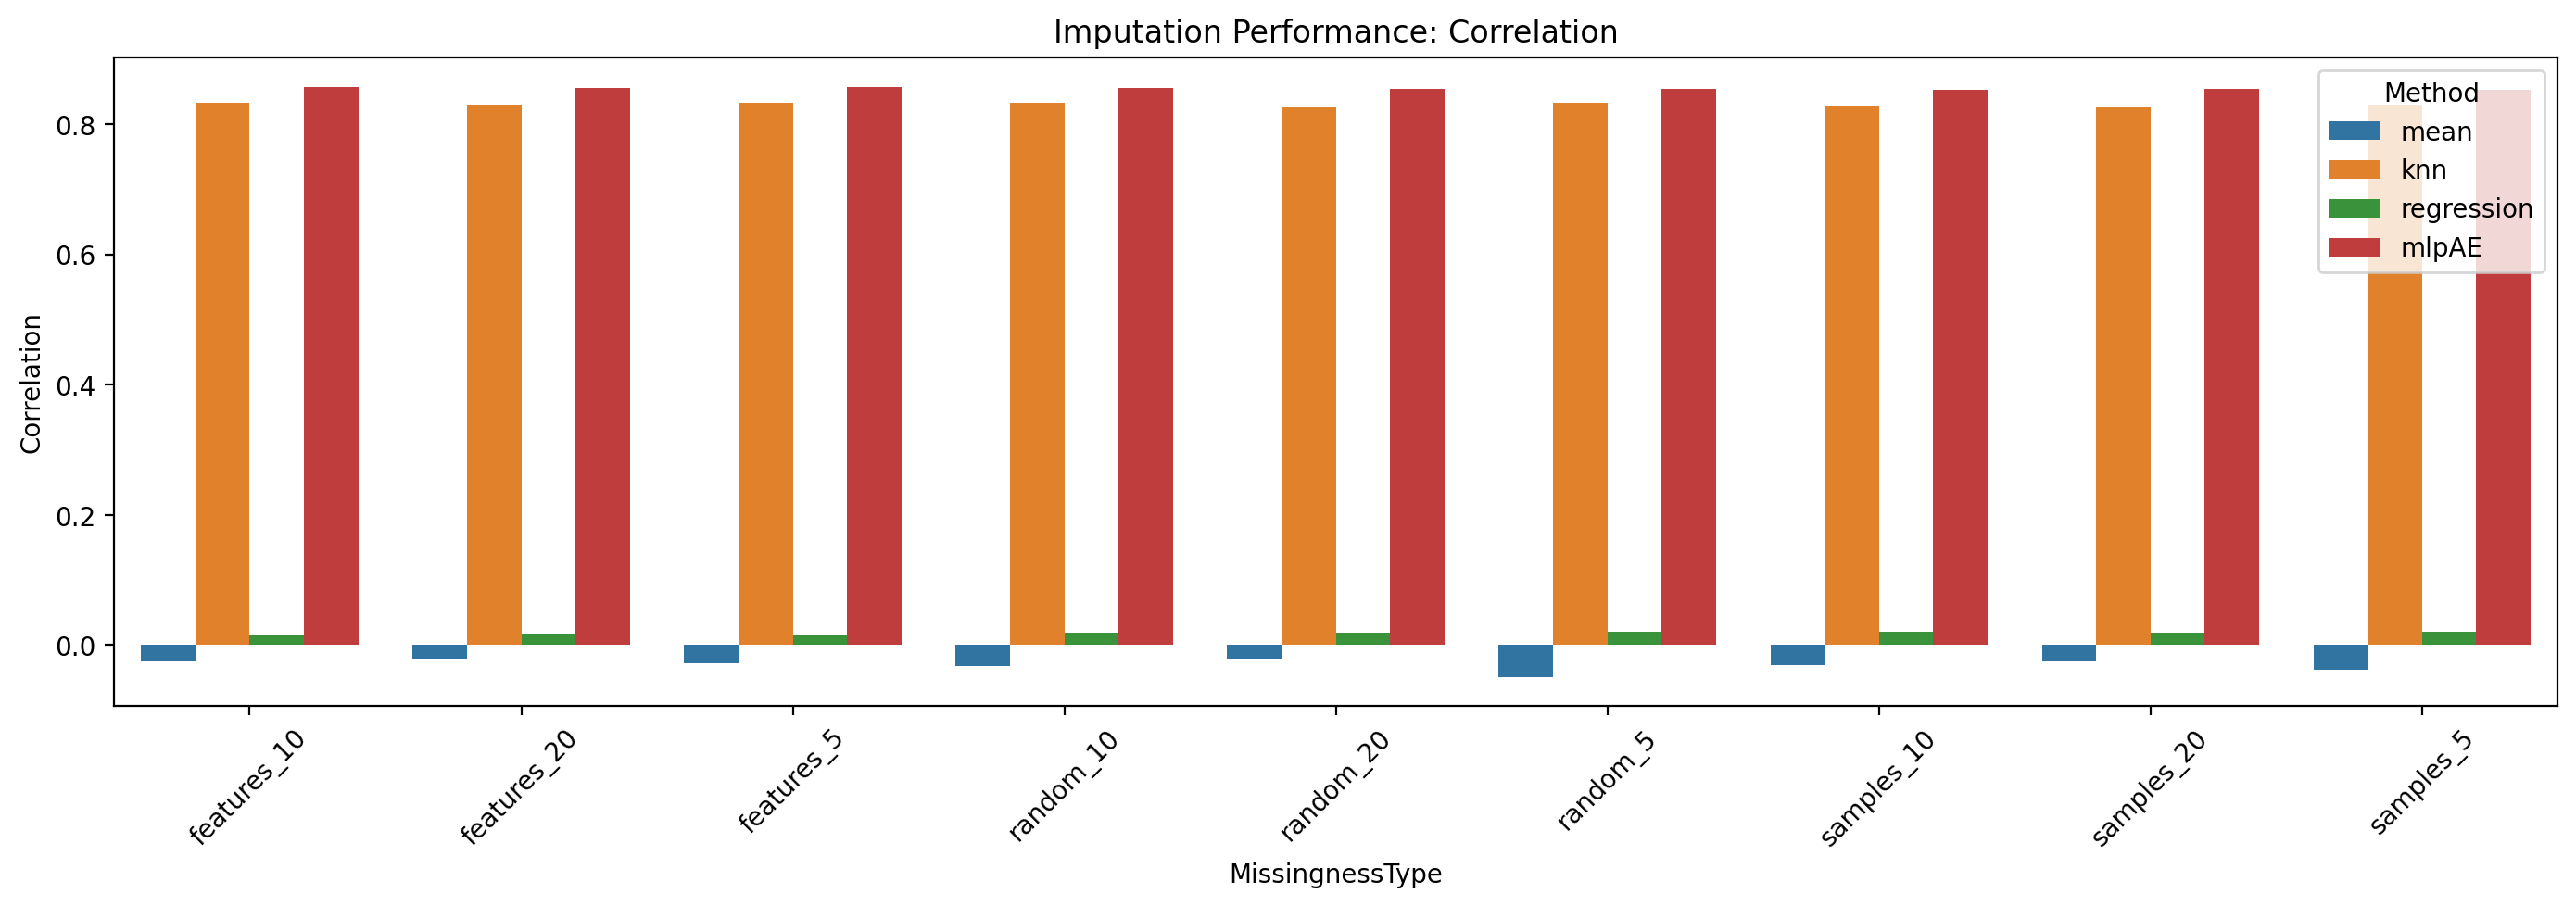

In [41]:
# ============================================================================
# Step 9.1: Grouped Bar Plots for Imputation Metrics
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Make dataset/method columns easier to read
plot_df = results_df.copy()
plot_df["MissingnessType"] = plot_df["Missingness"].str.replace("CNV_missing_", "")
plot_df["Level"] = plot_df["MissingnessType"].str.extract("(\d+)$")
plot_df["Type"] = plot_df["MissingnessType"].str.replace("_\d+$", "")

metrics = ["MSE", "R2", "Correlation"]

for metric in metrics:
    plt.figure(figsize=(14,5))
    sns.barplot(
        data=plot_df,
        x="MissingnessType",
        y=metric,
        hue="Method",
        palette="tab10"
    )
    plt.title(f"Imputation Performance: {metric}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Step 9.2 : Summary Table: Average Accuracy per Method

In [42]:
# ============================================================================
# Step 9.2: Average metrics per Method
# ============================================================================

avg_df = results_df.groupby("Method")[["MSE", "R2", "Correlation"]].mean()
avg_df = avg_df.sort_values("MSE")
avg_df

MSE        R2  Correlation
Method                                     
mlpAE       0.269191  0.730141     0.854770
knn         0.314639  0.684591     0.830203
regression  0.997276  0.000293     0.018924
mean        0.997834 -0.000267    -0.029738

# Step 9.3 : Best/Worst Case Examples

In [43]:
# ============================================================================
# Step 9C=.3: Best/Worst Cases
# ============================================================================

# Best = highest correlation
best_corr = results_df.loc[results_df["Correlation"].idxmax()]
worst_corr = results_df.loc[results_df["Correlation"].idxmin()]

print("Best Case:\n", best_corr, "\n")
print("Worst Case:\n", worst_corr)

Best Case:
 Missingness    CNV_missing_features_10
Method                           mlpAE
MSE                           0.265208
R2                            0.734027
Correlation                   0.857007
Name: 3, dtype: object 

Worst Case:
 Missingness    CNV_missing_random_5
Method                         mean
MSE                        1.001019
R2                        -0.000255
Correlation               -0.048534
Name: 20, dtype: object


# Step 9.4: Interpretation of the Imputation Results 
**The results show a big difference between the four imputation methods. Mean imputation and regression perform poorly, with MSE close to 1 and almost no correlation with the real CNV values. This means they fail to recover meaningful biological patterns. KNN does better and provides reasonable accuracy across all missingness levels. The autoencoder performs the best overall. It achieves the lowest MSE, the highest R² (around 0.73), and the strongest correlation (around 0.85). This shows that the autoencoder learns useful relationships between mRNA and CNV, making it the most effective method for filling in missing genomic data.**

# Step 10: Downstream Classification

In [44]:
# ============================================================================
# Step 10: Downstream Classification (Original CNV vs Imputed CNV)
# Random Forest classifier on 32 cancer types
# ============================================================================

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Directories
MISSING_DIR = "/home/jupyter/missingness_versions"
BASELINE_DIR = "/home/jupyter/baseline_imputations"
AE_DIR = "/home/jupyter/autoencoder_imputations"

# Ground truth CNV (scaled)
X_true = CNV_scaled.values
y = labels  # cancer labels

# -----------------------------
# Helper function
# -----------------------------
def evaluate_classifier(X, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        random_state=42
    )

    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    return {
        "Dataset": label,
        "Accuracy": accuracy_score(y_test, pred),
        "F1_macro": f1_score(y_test, pred, average="macro")
    }

# -----------------------------
# Evaluate Original CNV
# -----------------------------
results = []
results.append(evaluate_classifier(X_true, "Original_CNV"))

# -----------------------------
# Evaluate baseline imputations
# -----------------------------
baseline_files = sorted([f for f in os.listdir(BASELINE_DIR) if f.endswith(".parquet")])

for file in baseline_files:
    df = pd.read_parquet(os.path.join(BASELINE_DIR, file))
    df = df.fillna(df.mean())
    results.append(evaluate_classifier(df.values, file.replace(".parquet", "")))

# -----------------------------
# Evaluate Autoencoder imputations
# -----------------------------
ae_files = sorted([f for f in os.listdir(AE_DIR) if f.endswith(".parquet")])

for file in ae_files:
    df = pd.read_parquet(os.path.join(AE_DIR, file))
    df = df.fillna(df.mean())
    results.append(evaluate_classifier(df.values, file.replace(".parquet", "")))

# Put into a DataFrame
clf_results_df = pd.DataFrame(results)

print("\nClassification evaluation complete!")
clf_results_df


Classification evaluation complete!


Dataset  Accuracy  F1_macro
0                         Original_CNV  0.444444  0.368220
1          CNV_missing_features_10_knn  0.449254  0.370834
2         CNV_missing_features_10_mean  0.442039  0.365040
3   CNV_missing_features_10_regression  0.445406  0.365164
4          CNV_missing_features_20_knn  0.447811  0.368444
5         CNV_missing_features_20_mean  0.436748  0.360750
6   CNV_missing_features_20_regression  0.443963  0.364479
7           CNV_missing_features_5_knn  0.448292  0.373398
8          CNV_missing_features_5_mean  0.439153  0.361420
9    CNV_missing_features_5_regression  0.438672  0.357261
10           CNV_missing_random_10_knn  0.446368  0.369078
11          CNV_missing_random_10_mean  0.444444  0.365706
12    CNV_missing_random_10_regression  0.442039  0.363119
13           CNV_missing_random_20_knn  0.443482  0.364448
14          CNV_missing_random_20_mean  0.417989  0.337125
15    CNV_missing_random_20_regression  0.428090  0.343310
16            CNV_missing_random_5_knn  0.442039  0.369445
17           CNV_missing_random_5_mean  0.441558  0.366926
18     CNV_missing_random_5_regression  0.443963  0.364428
19          CNV_missing_samples_10_knn  0.449735  0.376546
20         CNV_missing_samples_10_mean  0.435305  0.351691
21   CNV_missing_samples_10_regression  0.438191  0.355936
22          CNV_missing_samples_20_knn  0.442520  0.369168
23         CNV_missing_samples_20_mean  0.424242  0.338742
24   CNV_missing_samples_20_regression  0.427609  0.340282
25           CNV_missing_samples_5_knn  0.455026  0.377335
26          CNV_missing_samples_5_mean  0.435786  0.354793
27    CNV_missing_samples_5_regression  0.440115  0.356826
28       CNV_missing_features_10_mlpAE  0.461760  0.379046
29       CNV_missing_features_20_mlpAE  0.475709  0.389139
30        CNV_missing_features_5_mlpAE  0.460798  0.379397
31         CNV_missing_random_10_mlpAE  0.461279  0.379985
32         CNV_missing_random_20_mlpAE  0.483405  0.393585
33          CNV_missing_random_5_mlpAE  0.452621  0.374851
34        CNV_missing_samples_10_mlpAE  0.461760  0.373315
35        CNV_missing_samples_20_mlpAE  0.466089  0.384447
36         CNV_missing_samples_5_mlpAE  0.454064  0.371836

# Assumptions on Noise
**We assume the noise in the data is random and not linked to any specific cancer type or gene. Any variation or missing values are treated as normal measurement errors. For the missingness experiments, we used simple noise levels of 5%, 10%, and 20%, assuming these ratios reflect realistic amounts of signal loss in large genomic studies. This helps the imputation models focus on learning the true biological patterns rather than trying to correct complicated or unknown noise sources.**